In [1]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code')
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code/TimeSeriesAnalysis')
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code/TimeSeriesAnalysis/')

In [2]:
import pandas as pd
import TimeSeriesAnalysis.tsa_lth.analysis as analysis
import TimeSeriesAnalysis.tsa_lth.modelling as modelling
import TimeSeriesAnalysis.tsa_lth.tests as tests
from TimeSeriesAnalysis.tsa_lth.tools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import copy
import pylab

In [3]:
def getARMA(data, A=0, C=0):
    A_free=A
    C_free=C
    model = modelling.PEM(data, A=A, C=C)
    if isinstance(A, int):
        A_free = [1]*(A+1)
    if isinstance(C, int):
        C_free = [1]*(C+1)
    model.set_free_params(A_free=A_free, C_free=C_free)
    model_fitted = model.fit(method='LS', bh=False)
    model_fitted.summary()
    return model_fitted


def checkNormal(data, remove=False, title=None):
    if remove:
        data = data[remove:]
    tests.check_if_normal(data)
    stats.probplot(data, dist="norm", plot=pylab)
    if title:
        plt.title(title)
    pylab.show()
    
    
def analyzeARMA(x, A=0, C=0, noLags=50, titleStr=None, return_val=False, normal_test=True, remove=False):
    model = getARMA(x, A=A, C=C)
    if isinstance(A, int): len_A = A
    else: len_A = len(A)
    if isinstance(C, int): len_C = C
    else: len_C = len(C)
    remove=max(len_A, len_C)
    res = model.resid
    acf_est, pacf_est = analysis.plotACFnPACF(res,noLags=noLags,titleStr=titleStr, return_val=True)
    tests.whiteness_test(res)
    if normal_test:
        checkNormal(acf_est, remove=remove, title='ACF')
        checkNormal(pacf_est, remove=remove, title='PACF')
    if return_val:
        return model, acf_est, pacf_est


def pred_k(y, A, C, x=None, B=None, s=0, k=[1], plot=True, var=True, transform=False, x_transform=False, inv_transform=False):
    
    # Initialize important variables
    if s>0:
        Astar = np.convolve(A, [1] + [0]*(s-1) + [-1])
    pred_resid_dict = {}
    var_y = np.var(y)
    yhat_k_df = pd.DataFrame({'True_val': y})
    y_transform = y.copy()
    
    # Transform data before calculating prediction
    if transform:
        y_transform = [transform(val) for val in y]
    if x_transform:
        x_transform = [x_transform(val) for val in x]

    for i in range(len(k)):
        # ARMAX process
        if x is not None:
            Fk, Gk = modelling.polydiv(C, A, k[i])
            BFk = np.convolve(B, Fk)
            Fhatk, Ghatk = modelling.polydiv(BFk, C, k[i])
            remove = max(len(Fhatk), len(Ghatk), len(Gk), 1)
            xhatk = modelling.filter(Ghatk, C, x) + modelling.filter(Fhatk, [1], x)
            yhatk = xhatk + modelling.filter(Gk, C, y_transform)
            yhatk = yhatk[remove:].tolist()
        else:
            # ARMA process
            Fk, Gk = modelling.polydiv(C, A, k[i])
            remove = max(len(Gk), len(C))
            yhatk = modelling.filter(Gk, C, y_transform, remove=remove).tolist()
            
        # Transform data back
        if transform:
            yhatk = [inv_transform(val) for val in yhatk]
        yhat_k_df[f'{k[i]}-step_pred'] = [np.NaN]*(remove) + yhatk 

        # Calculate prediction
        pred_error = y[len(y)-len(yhatk):] - np.array(yhatk)
        noise_var = np.var(pred_error)
        pred_resid_dict[k[i]] = pred_error
        normalized_noise_var = noise_var/var_y

        if var:
            print(f'Estimated noise variance for {k[i]}-step prediction is {round(noise_var,6)}')
            print(f'Estimated standardized noise variance for {k[i]}-step prediction is {round(normalized_noise_var,6)}')
            if x is not None:
                MSE_x = np.var(y[len(y)-len(xhatk):] - xhatk)
                var_y = np.var(y[len(y)-len(xhatk):])
                MSR_x = np.var(xhatk)
                print(f'Total variance: {round(var_y,4)}')
                print(f'Variance explained by x: {round(MSR_x,4)}')
    if plot:
        yhat_k_df.plot(title='Prediction')
    return yhat_k_df, pred_resid_dict


    
def get_C(y, x, A, B, C, t=1):
    nonzero_indexA = np.nonzero(A)[0][1:]
    nonzero_indexB = np.nonzero(B)[0]
    nonzero_indexC = np.nonzero(C)[0][1:]
    y_part = [y[t-i] for i in nonzero_indexA]
    x_part = [x[t-i] for i in nonzero_indexB]
    name_y = ['a_'+str(i) for i in nonzero_indexA]
    name_x = ['b_'+str(i) for i in nonzero_indexB]
    name_e = ['c_'+str(i) for i in nonzero_indexC]
    
    yhat_1_df, e = pred_k(y,x=x, A=A, B=B, C=C, plot=False, var=False)
    e_part = [e[1][t-max(len(A),len(B),len(C))-i] for i in nonzero_indexC]
    
    return np.array(y_part + e_part + x_part), name_y + name_e + name_x


# Using data perform kalman gain to get the AR(1) coefficient
def kalmanARMAX(y, x, A, B, C, n_validation, Re= None, Rw=1e-6, Rxx1=None, xtt1=None, plot=True, var=True):
    N = len(y)
    n_param = np.count_nonzero(A) + np.count_nonzero(B) + np.count_nonzero(C) - 2
    At = np.eye(n_param)

    if Re is None:
        Re = 1 * np.eye(n_param)
    if Rxx1 is None:
        Rxx1 = 1 * np.eye(n_param)
    if xtt1 is None:
        xtt1 = np.array([0]*n_param)
    # Initialize parameter
    Xsave = np.zeros((n_param, N))
    ehat = np.zeros(N)
    yhat = np.zeros(N)
    start_t = len(C)+max(len(A),len(B),len(C))
    for t in range(start_t, N):
        Ct, names = get_C(y,x,A,B,C, t)
        Ct = Ct.reshape(1,-1)
        Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
        Kt = np.dot(np.dot(Rxx1, Ct.T), np.linalg.inv(Ryy))
        yhat[t] = np.dot(Ct, xtt1).item()

        ehat[t] = y[t] - yhat[t]
        Xsave[:,t] = xtt1 + np.dot(Kt, ehat[t]).T
        Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)

        xtt1 = np.dot(At, Xsave[:,t])
        Rxx1 = np.dot(np.dot(At, Rxx), At.T) + Re

    noise_var = sum(np.square(y[-n_validation-1:-1] - yhat[-n_validation:])/len(yhat[-n_validation:]))
    if var:
        print(f'The variance of predicted noise: {round(noise_var,6)}')
    
    if plot:
        # Plot the estimated y with actual y
        plt.plot(y[-n_validation-1:-1], color='darkblue', label='Actual')
        plt.plot(yhat[-n_validation:], color='maroon', label='Estimated')
        plt.title('Plot of y value')
        plt.legend()
        plt.show()
    
    return Xsave, yhat, noise_var


def removeParamARMAX(y,x,A,B,C,n_validation, threshold):
    N = len(y)
    Ct, names = get_C(y,x,A,B,C)
    n = np.count_nonzero(A) + np.count_nonzero(B) + np.count_nonzero(C) - 2
    nonzero_indexA = [np.nonzero(A)[0][1:]]
    nonzero_indexB = np.nonzero(B)[0]
    nonzero_indexC = np.nonzero(C)[0][1:]
    n_param = n - 1
    name_copy = copy.deepcopy(names)
    new_A = copy.deepcopy(A)
    new_B = copy.deepcopy(B)
    new_C = copy.deepcopy(C)
    noise_var_ls = []
    for i in range(0,len(name_copy)):
        new_KA = copy.deepcopy(A)
        new_KB = copy.deepcopy(B)
        new_KC = copy.deepcopy(C)
        curr_param = int(name_copy[i][2:])

        if name_copy[i][0] == 'a':
            new_KA[curr_param] = 0
        if name_copy[i][0] == 'b':
            new_KB[curr_param] = 0
        if name_copy[i][0] == 'c':
            new_KC[curr_param] = 0

        Xsave, yhat, noise_var = kalmanARMAX(y,x,new_KA,new_KB,new_KC,n_validation, plot=False, var=False)
        noise_var = sum(np.square(y[-n_validation-1:-1] - yhat[-n_validation:])/len(yhat[-n_validation:]))
        noise_var_ls.append(noise_var)
        print(f'The variance of predicted noise when {name_copy[i]} is removed: {round(noise_var,6)}')
        
    
    if min(noise_var_ls) > threshold:
        print(f'It is better to not remove any parameters')
    else:
        min_index = noise_var_ls.index(min(noise_var_ls))  
        remove_variable = names[min_index]
        remove_param = int(remove_variable[2:])
        if remove_variable[0] == 'a':
            new_A[remove_param] = 0
        if remove_variable[0] == 'b':
            new_B[remove_param] = 0
        if remove_variable[0] == 'c':
            new_C[remove_param] = 0
        print(f'Parameter to be removed: {remove_variable}')
    return new_A, new_B, new_C, min(noise_var_ls)

# Import data

In [4]:
ElGeneina_mat = analysis.mat2np('./data/ElGeneina.mat')[0]
Kassala_mat = analysis.mat2np('./data/Kassala.mat')[0]

In [5]:
ElGeneina = pd.DataFrame()
col_names = ['nvdi', 'nvdi_t', 'rain', 'rain_t', 'rain_org', 'rain_org_t']
for i in range(len(ElGeneina_mat)):
    ElGeneina = pd.concat([ElGeneina, pd.DataFrame(ElGeneina_mat[i]).astype(float).round(6)], axis=1, ignore_index=True)
ElGeneina.columns = col_names
    
Kassala = pd.DataFrame()
for i in range(len(Kassala_mat)):
    Kassala = pd.concat([Kassala, pd.DataFrame(Kassala_mat[i]).astype(float).round(6)], axis=1, ignore_index=True)
Kassala.columns = col_names
ElGeneina.head(10)

,nvdi,nvdi_t,rain,rain_t,rain_org,rain_org_t
0,140.2,1982.013889,0.0,1960.013889,0.0,1960.041667
1,147.2,1982.041667,0.0,1960.041667,0.0,1960.125000
2,145.7,1982.069444,0.0,1960.069444,0.0,1960.208333
3,145.8,1982.097222,0.0,1960.097222,0.0,1960.291667
4,145.0,1982.125000,0.0,1960.125000,0.0,1960.375000
5,140.2,1982.152778,0.0,1960.152778,17.2,1960.458333
6,142.6,1982.180556,0.0,1960.180556,233.2,1960.541667
7,142.7,1982.208333,0.0,1960.208333,219.4,1960.625000
8,144.6,1982.236111,0.0,1960.236111,78.7,1960.708333
9,146.3,1982.263889,0.0,1960.263889,6.1,1960.791667


- High NDVI indicates presence of vegetation
- Low NDVI indicates barren ground, water, snow, ice, etc
- NDVI are stored as unsigned (8-bit) integers (i.e., between 0 and 255), and thus needs to be rescaled to [−1,1].
- NDVI is measured three times every month (day 1-10, 11-20, 21-end) 
- Rain_org is measured once every month
- Rain is linear interpolation of Rain_org to match NDVI
- Both NDVI and rain data had missing data points but were filled with Matlab misdata function.

# Recursive reconstruction of rain data

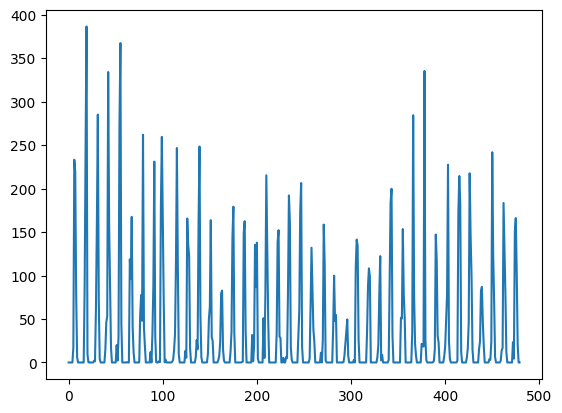

In [6]:
plt.plot(ElGeneina['rain_org'])
plt.show()

## Transforming data

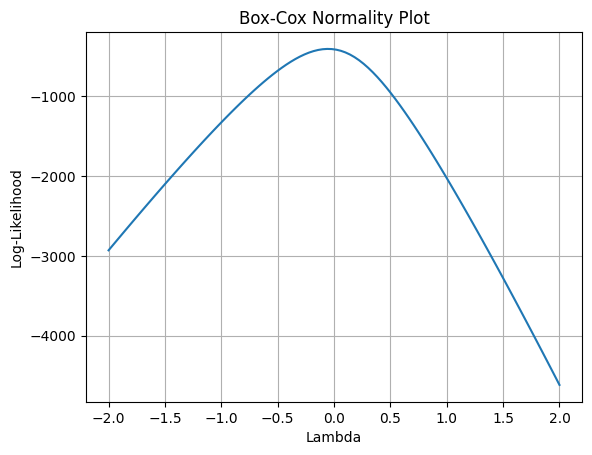

Max Lambda = -0.052951918377049746.
ln(y) could be an appropriate transformation.


In [7]:
# Here we add a very small value to allow y to be strictly positive.
y = ElGeneina['rain_org'].values
y = y[:len(y)-960]
y = y + 1e-2
max_lambda = analysis.box_cox(y, 1)

Although ln(y) is an appropriate transformation, the structure of $Y_t = x_t + x_{t-1} + x_{t-2}$ makes it difficult for us to revert the transformation back. Using the estimation $\ln{Y_t} =  \ln{x_t} + \ln{x_{t-1}} + \ln{x_{t-2}}$ does not give us a good estimate. Hence, we will be using no transformation here.

## Modelling rain with Kalman

Here we estimate the optimal AR(1) coeffeicient to use, limiting the options to have the polynomial roots inside the unit circle to have the process stable.

minimum value of a1 that minimizes the error is -0.99
estimated variance of residual is 41.73


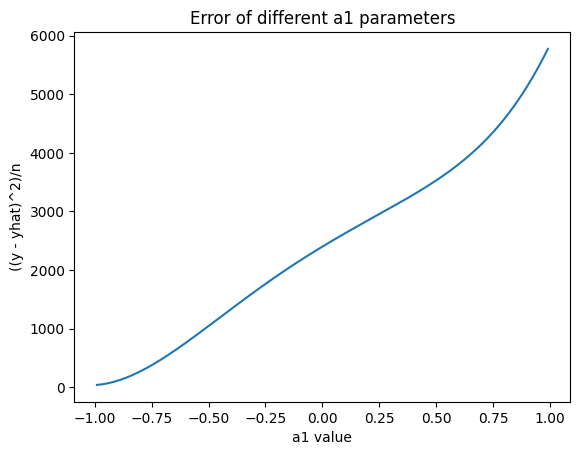

In [8]:
# Finding the minimum value of A1 that minimizes the error.
N = len(y)
a1_ls = np.arange(-.99, 1, .01)
error_ls = []
for a in a1_ls:
    a1 = a    # Value of A1 parameter
    A = np.array([[-a1, 0, 0], [1, 0, 0], [0, 1, 0]])
    Re = 50 * np.eye(3)   #   How fast changes of estimates are reflected. Since y_t = x_t + x_t-1 + x_t-2 exactly, we have to use big values of Re to see this.
    Rw = 100    # How noisy the estimate will be

    Rxx1 = 10 * np.eye(3)    # How confident we are with initial states
    xtt1 = np.array([0]*3)    # Set initial states as 0

    Xsave = np.zeros((3, N))
    ehat = np.zeros(N)
    yhat = np.zeros(N)

    for t in range(0, N):
        Ct = np.array([1,1,1]).reshape(1, -1)
        Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
        Kt = np.dot(np.dot(Rxx1, Ct.T), np.linalg.inv(Ryy))
        yhat[t] = np.dot(Ct, xtt1).item()

        ehat[t] = y[t] - yhat[t]
        Xsave[:,t] = xtt1 + np.dot(Kt, ehat[t]).T
        Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)

        xtt1 = np.dot(A, Xsave[:,t])
        Rxx1 = np.dot(np.dot(A, Rxx), A.T) + Re
    
    error = sum(np.square(np.subtract(y[:-1],yhat[1:])))/(len(y)-1)
    error_ls.append(error)

min_a1 = a1_ls[error_ls.index(min(error_ls))]
print(f'minimum value of a1 that minimizes the error is {round(min_a1, 2)}')
print(f'estimated variance of residual is {round(min(error_ls), 2)}')
plt.plot(a1_ls, error_ls)

plt.title('Error of different a1 parameters')
plt.xlabel('a1 value')
plt.ylabel('((y - yhat)^2)/n')
plt.show()


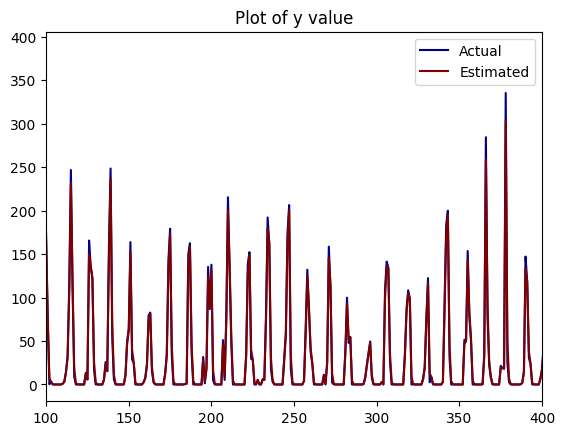

In [9]:
# Using data perform kalman gain to get the AR(1) coefficient
N = len(y)
a1 = min_a1   # Value of A1 parameter
A = np.array([[-a1, 0, 0], [1, 0, 0], [0, 1, 0]])
Re = 50 * np.eye(3)   #   How fast changes of estimates are reflected. Since y_t = x_t + x_t-1 + x_t-2 exactly, we have to use big values of Re to see this.
Rw = 100    # How noisy the estimate will be

Rxx1 = 10 * np.eye(3)    # How confident we are with initial states
# xtt1 = np.array([y[0]/3]*3)    # Set initial states as the first value of rain/3
xtt1 = np.array([0]*3)    # Set initial states as 0

Xsave = np.zeros((3, N))
ehat = np.zeros(N)
yhat = np.zeros(N)

for t in range(0, N):
    Ct = np.array([1,1,1]).reshape(1, -1)
    Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
    Kt = np.dot(np.dot(Rxx1, Ct.T), np.linalg.inv(Ryy))
    yhat[t] = np.dot(Ct, xtt1).item()

    ehat[t] = y[t] - yhat[t]
    Xsave[:,t] = xtt1 + np.dot(Kt, ehat[t]).T
    Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)

    xtt1 = np.dot(A, Xsave[:,t])
    Rxx1 = np.dot(np.dot(A, Rxx), A.T) + Re
    
# Plot the estimated y with actual y
x_val = []
for i in range(len(Xsave[0])):
    x_val += [Xsave[0][i], Xsave[1][i], Xsave[2][i]]
plt.plot(y[:-1], color='darkblue', label='Actual')
plt.plot(yhat[1:], color='maroon', label='Estimated')
plt.xlim(100, 400)
plt.title('Plot of y value')
plt.legend()
plt.show()

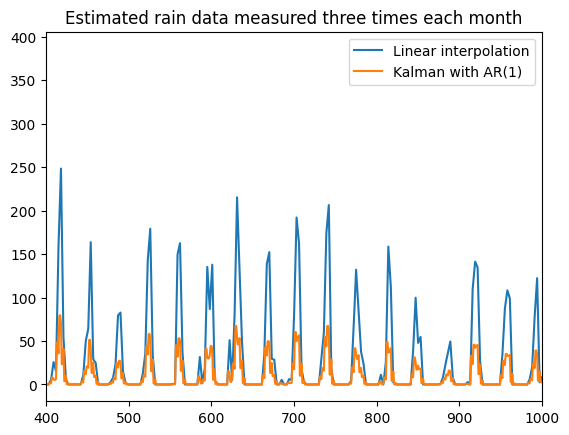

In [10]:
# Plot the estimated rain with its linear interpolated
plt.plot(ElGeneina['rain'], label='Linear interpolation')
plt.plot(x_val[1:], label='Kalman with AR(1)')
plt.title('Estimated rain data measured three times each month')
plt.xlim(400,1000)
plt.legend()
plt.show()

In [11]:
print(f"There is a difference of {round(ElGeneina['rain_org'].sum() - sum(x_val),4)} mm of total rain")
print(f"There is a difference of {round(min(error_ls), 2)} mm of rain per month")

There is a difference of 31.145 mm of total rain
There is a difference of 41.73 mm of rain per month


### Test Q1 with Simulated Data

Standard deviation of y error: 4.4518


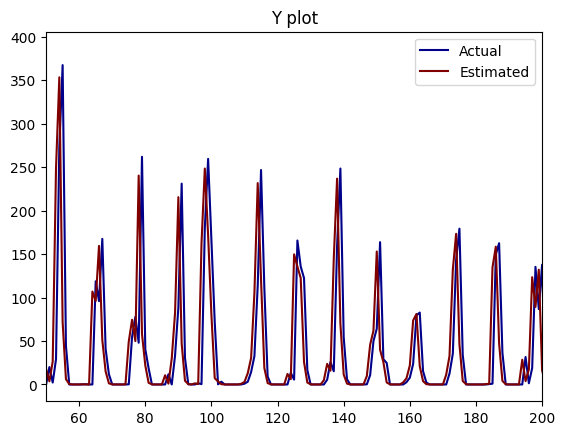

Standard deviation of x error: 1.4144


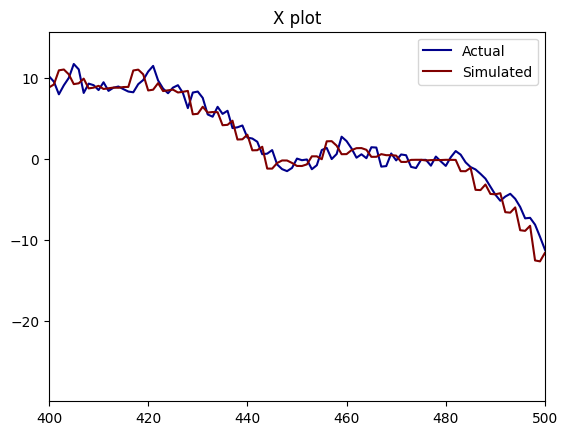

In [12]:
# Test with simulated data
test = modelling.simulateARMA(AR=[1, min_a1], size=800)
test = test[50:]
y_test = [test[i]+test[i+1]+test[i+1] for i in range(0, len(test),3)]
N_test = len(y_test)
Rxx1 = 100 * np.eye(3)    # How confident we are with initial states
xtt1 = np.array([0]*3)    # Set initial states as 0

Xsave_test = np.zeros((3, N_test))
ehat_test = np.zeros(N_test)
yhat_test = np.zeros(N_test)

for t in range(0, N_test):
    Ct = np.array([1,1,1]).reshape(1, -1)
    Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
    Kt = np.dot(np.dot(Rxx1, Ct.T), np.linalg.inv(Ryy))
    yhat_test[t] = np.dot(Ct, xtt1).item()
    
    ehat_test[t] = y_test[t] - yhat_test[t]
    Xsave_test[:,t] = xtt1 + np.dot(Kt, ehat_test[t]).T
    Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)
    
    xtt1 = np.dot(A, Xsave_test[:,t])
    Rxx1 = np.dot(np.dot(A, Rxx), A.T) + Re
    
# Plot the estimated x and y
x_val_test = []
for i in range(len(Xsave_test[0])):
    x_val_test += [Xsave_test[0][i], Xsave_test[1][i], Xsave_test[2][i]]

print(f'Standard deviation of y error: {round(np.sqrt(sum(np.square(yhat_test[2:] - y_test[:-2]))/len(yhat_test[2:])),4)}')
plt.plot(y[:-2], color='darkblue', label='Actual')
plt.plot(yhat[2:], color='maroon', label='Estimated')
plt.xlim(50, 200)
plt.title('Y plot')
plt.legend()
plt.show()
plt.figure()
print(f'Standard deviation of x error: {round(np.sqrt(sum(np.square(x_val_test[3:] - test[:-3]))/len(x_val_test[3:])),4)}')
plt.plot(test[:], color='darkblue', label='Actual')
plt.plot(x_val_test[3:], color='maroon', label='Simulated')
plt.xlim(400,500)
plt.title('X plot')
plt.legend()
plt.show()

# Modeling and validation for El-Geneina

In [13]:
ElGeneina['estimated_rain'] = x_val[1:] + [0]
ElGeneina_df = ElGeneina[~np.isnan(ElGeneina['nvdi_t'])]
ElGeneina_df.head(10)

,nvdi,nvdi_t,rain,rain_t,rain_org,rain_org_t,estimated_rain
0,140.2,1982.013889,0.0,1960.013889,0.0,1960.041667,0.000769
1,147.2,1982.041667,0.0,1960.041667,0.0,1960.125000,0.000769
2,145.7,1982.069444,0.0,1960.069444,0.0,1960.208333,0.002535
3,145.8,1982.097222,0.0,1960.097222,0.0,1960.291667,0.002547
4,145.0,1982.125000,0.0,1960.125000,0.0,1960.375000,0.002287
5,140.2,1982.152778,0.0,1960.152778,17.2,1960.458333,0.003217
6,142.6,1982.180556,0.0,1960.180556,233.2,1960.541667,0.003247
7,142.7,1982.208333,0.0,1960.208333,219.4,1960.625000,0.002989
8,144.6,1982.236111,0.0,1960.236111,78.7,1960.708333,0.003290
9,146.3,1982.263889,0.0,1960.263889,6.1,1960.791667,0.003323


We divide our data to modelling, validating, and testing

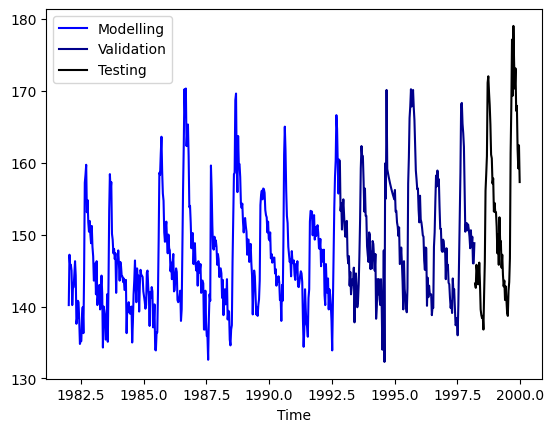

In [14]:
n_modelling = round(ElGeneina_df.shape[0] * .6)
n_validation = round(ElGeneina_df.shape[0] * .3)
n_test = round(ElGeneina_df.shape[0] * .1)
EG_modelling = ElGeneina_df.iloc[:n_modelling]
EG_validation = ElGeneina_df.iloc[n_modelling:n_modelling+n_validation]
EG_testing = ElGeneina_df.iloc[n_modelling+n_validation:]
plt.plot(EG_modelling['nvdi_t'],EG_modelling['nvdi'], color='b', label='Modelling')
plt.plot(EG_validation['nvdi_t'],EG_validation['nvdi'], color='darkblue', label='Validation')
plt.plot(EG_testing['nvdi_t'], EG_testing['nvdi'], color='black', label='Testing')
plt.legend()
plt.xlabel('Time')
plt.show()

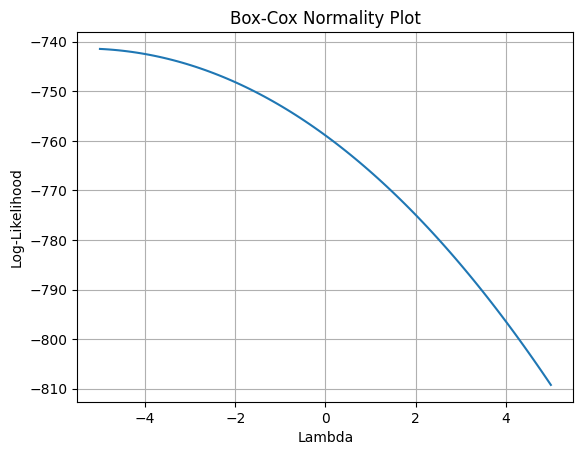

Max Lambda = -5.380919935278785.
y^-3 could be an appropriate transformation.


In [15]:
EG_nvdi = EG_modelling['nvdi'].values
max_lambda = analysis.box_cox(EG_nvdi, lamRange=[-5,5])

Here we will be using $y^{-1}$ as there isn't much difference in the log-likelihood, a bigger transformation will also lead to more errors during the modelling phase.

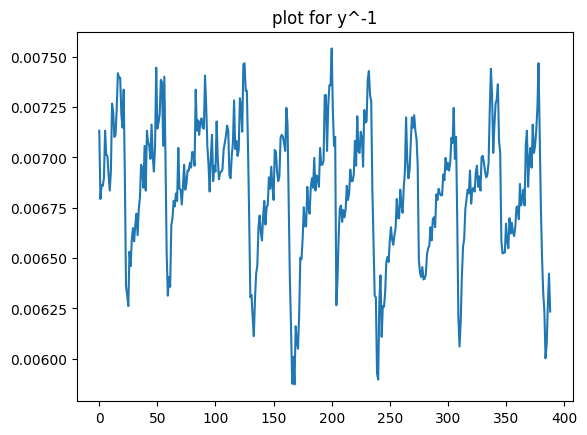

In [16]:
# We try plotting for y^-1
transformed_EG_nvdi = [i**-1 for i in EG_nvdi]
plt.plot(transformed_EG_nvdi)
plt.title('plot for y^-1')
plt.show()

## Without percipitation

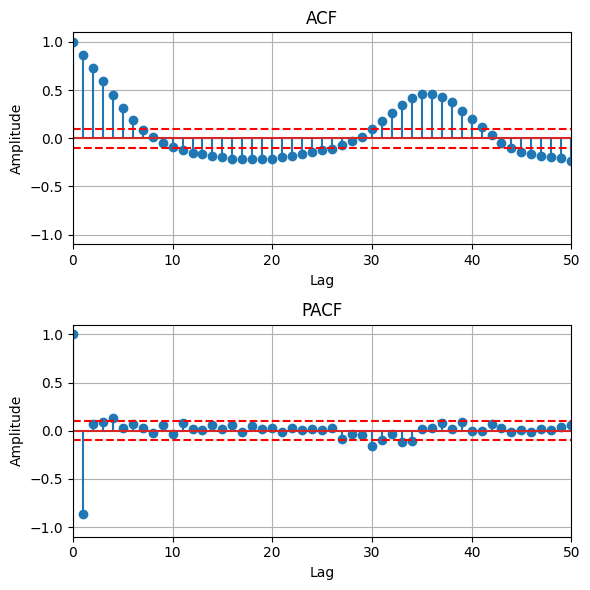

In [17]:
modelling.plotACFnPACF(transformed_EG_nvdi, noLags=50)

Here we observe a season of 36, we will first get rid of this

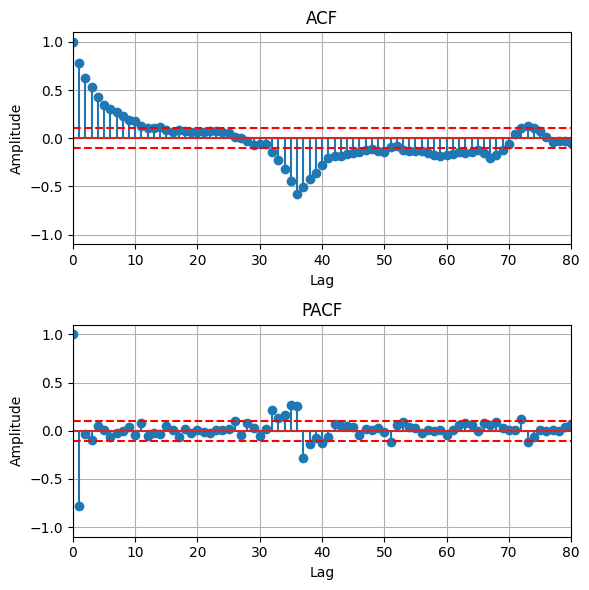

In [18]:
AS = [1] + [0]*35 + [-1]
EG_nvdi_nabla36 = modelling.filter(AS,1,transformed_EG_nvdi, remove=True)
modelling.plotACFnPACF(EG_nvdi_nabla36, noLags=80)

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.7828(±0.0332)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 37.55%
FPE : 0.0  MSE : 0.0
AIC : -4999.025   BIC : -4995.161



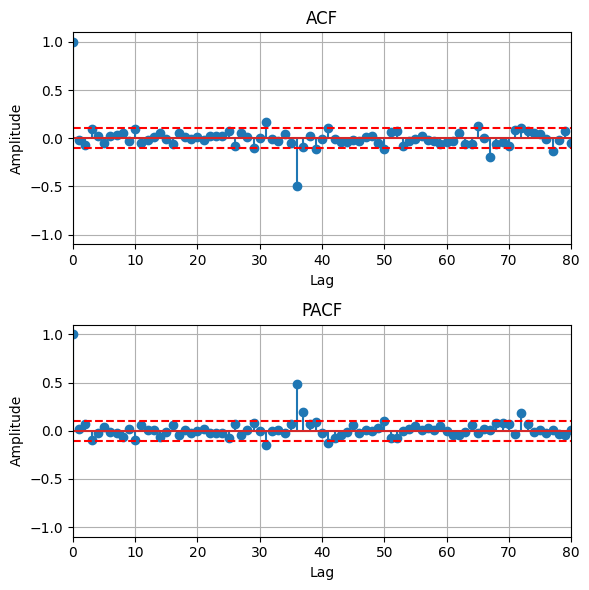

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 16.18 < 31.41)
  McLeod-Li test:        False (white if 52.24 < 31.41)
  Monti test:            True (white if 15.84 < 31.41)
  Sign change test:      True (white if 0.54 in [0.45,0.55])


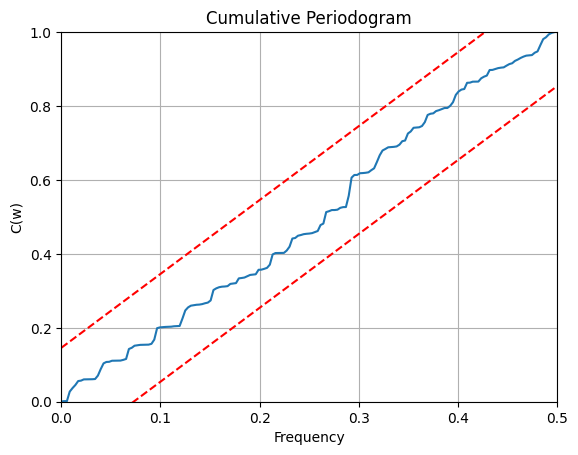

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


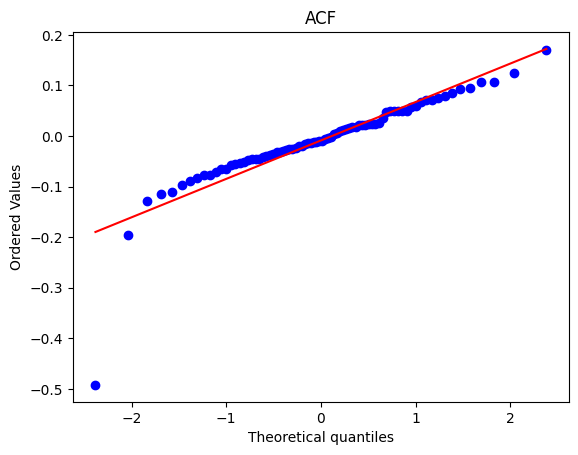

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


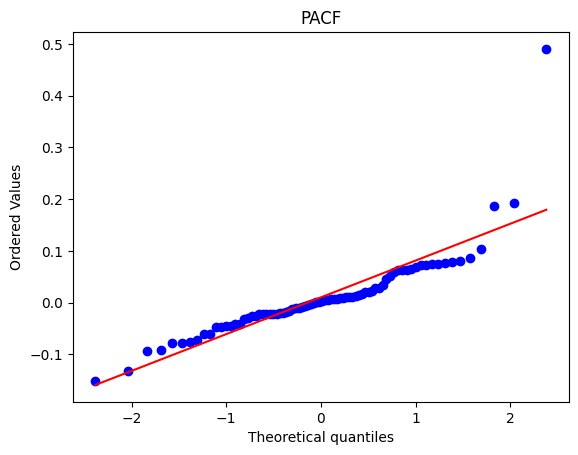

In [19]:
# Here we try to model an AR(1)
AS = 1
model_ar, ACF_ar, PACF_ar = analyzeARMA(EG_nvdi_nabla36, A=AS,noLags=80, return_val=True)

Here $c_{36}$ seems reasonable as we are done with the a parameters. We try to give it a $c_{36}$ parameter

Discrete-time MA model: y(t) = C(z)e(t)

C(z) = 1.0 - 0.7222(±0.0384)·z⁻³⁶

Polynomial orders: nC = 36
Number of free coefficients: 1
Fit to estimation data (NRMSE): 18.67%
FPE : 0.0  MSE : 0.0
AIC : -5144.637   BIC : -5140.773



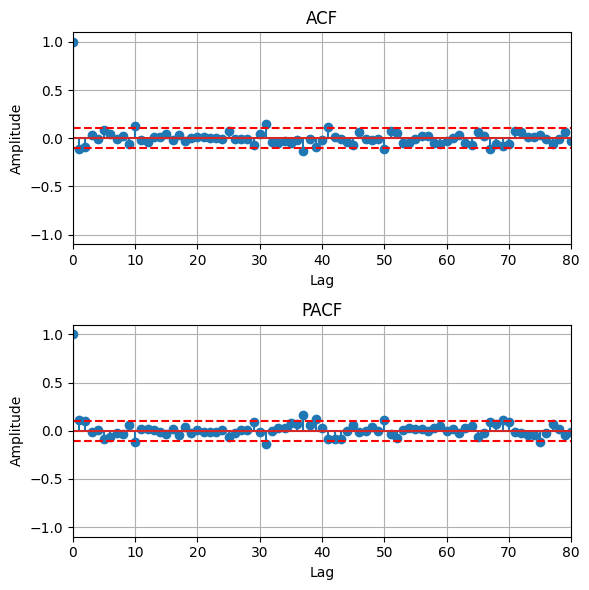

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 20.70 < 31.41)
  McLeod-Li test:        False (white if 61.87 < 31.41)
  Monti test:            True (white if 21.49 < 31.41)
  Sign change test:      True (white if 0.55 in [0.45,0.55])


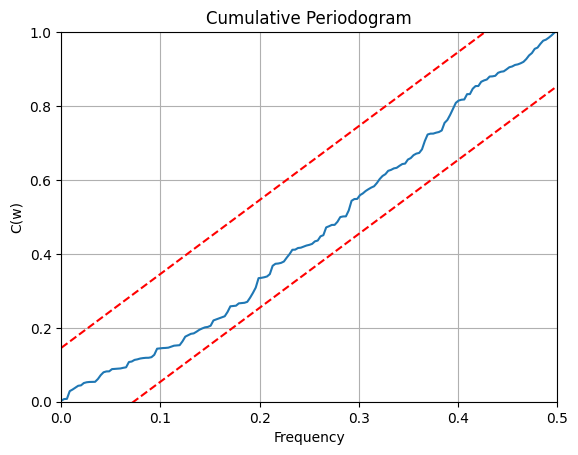

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


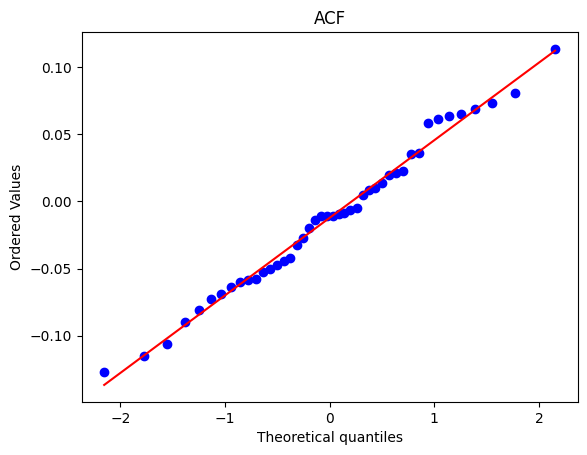

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


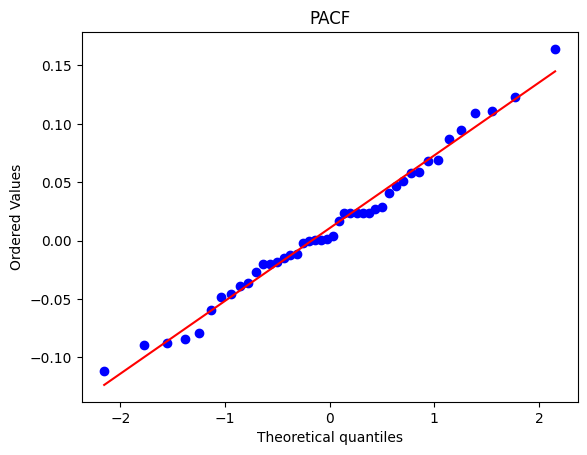

In [20]:
CS = [1] + [0]*35 + [1]
model_ma, ACF_ma, PACF_ma = analyzeARMA(model_ar.resid, C=CS,noLags=80, return_val=True)

Here we see that our error is reasonably normal based on our tests (it satisfies the cumulative periodogram test and the Monti-test, and that the ACF and PACF are reasonably normal). Now we re-estimate all the parameters together.

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.9996(±0.0024)·z⁻¹ + 0.9271(±0.6273)·z⁻³⁶ - 0.9265(±0.6273)·z⁻³⁷
C(z) = 1.0 + 0.921(±0.6433)·z⁻³⁶

Polynomial orders: nA = 37    nC = 36
Number of free coefficients: 4
Fit to estimation data (NRMSE): 49.82%
FPE : 0.0  MSE : 0.0
AIC : -5134.622   BIC : -5119.168



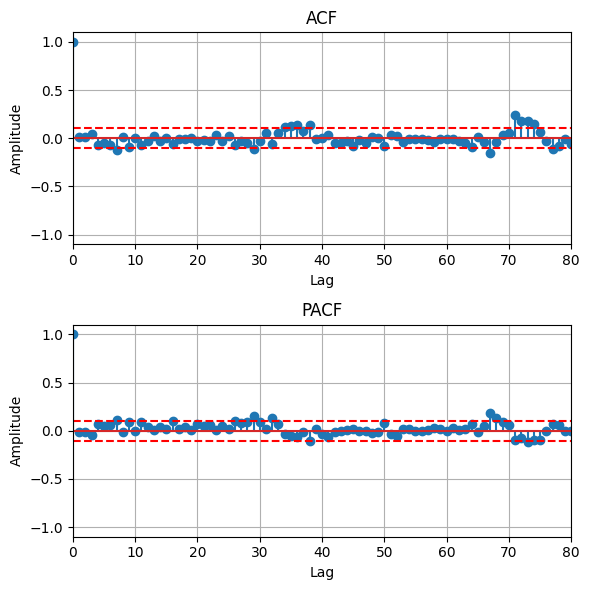

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 17.28 < 31.41)
  McLeod-Li test:        True (white if 27.06 < 31.41)
  Monti test:            True (white if 23.18 < 31.41)
  Sign change test:      True (white if 0.54 in [0.45,0.55])


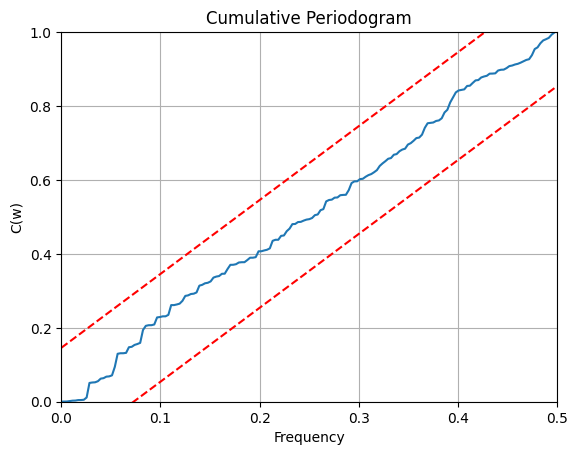

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


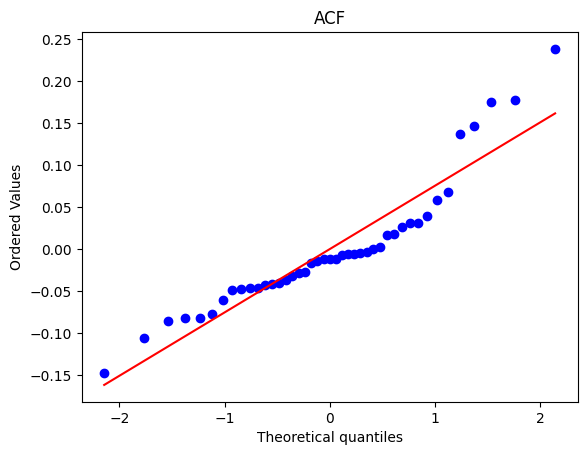

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


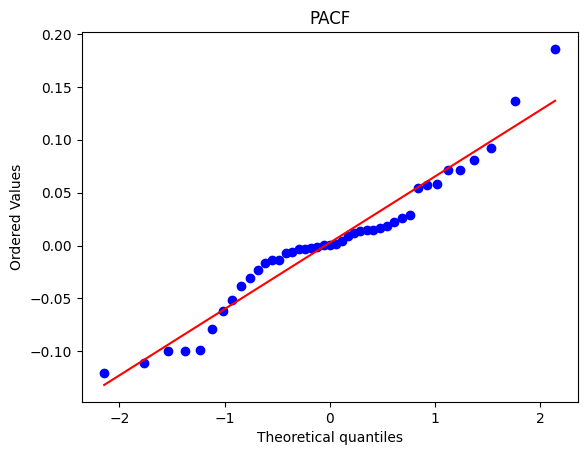

In [21]:
AS = [1, 1] + [0]*34 + [1,1]
CS = [1] + [0]*35 + [1]
model_full_tr, ACF_full_tr, PACF_full_tr = analyzeARMA(transformed_EG_nvdi, A=AS, C=CS, noLags=80, return_val=True, remove=True)

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.8817(±0.027)·z⁻¹ - 0.2261(±0.0523)·z⁻³⁶ + 0.1084(±0.0525)·z⁻³⁷

Polynomial orders: nA = 37
Number of free coefficients: 3
Fit to estimation data (NRMSE): 51.82%
FPE : 0.0  MSE : 0.0
AIC : -5165.191   BIC : -5153.6



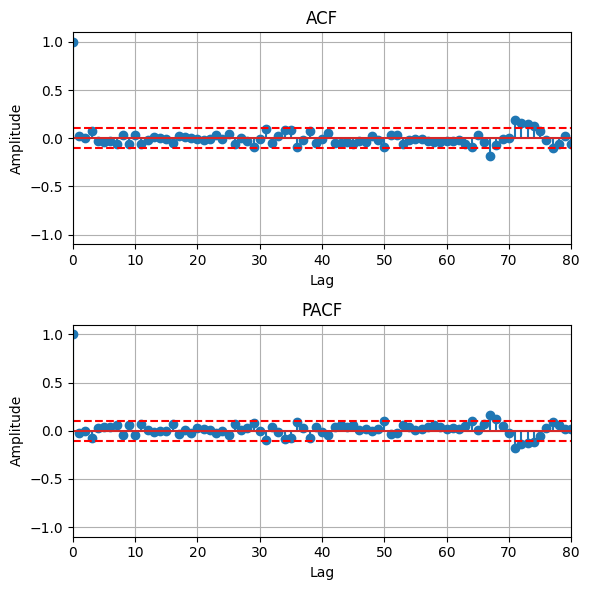

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 9.76 < 31.41)
  McLeod-Li test:        False (white if 48.75 < 31.41)
  Monti test:            True (white if 11.96 < 31.41)
  Sign change test:      True (white if 0.54 in [0.45,0.55])


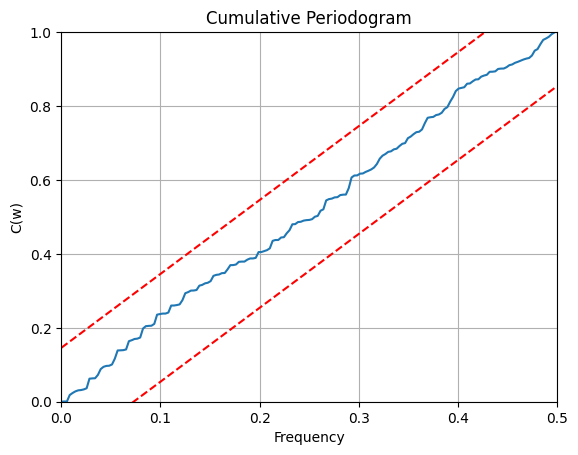

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


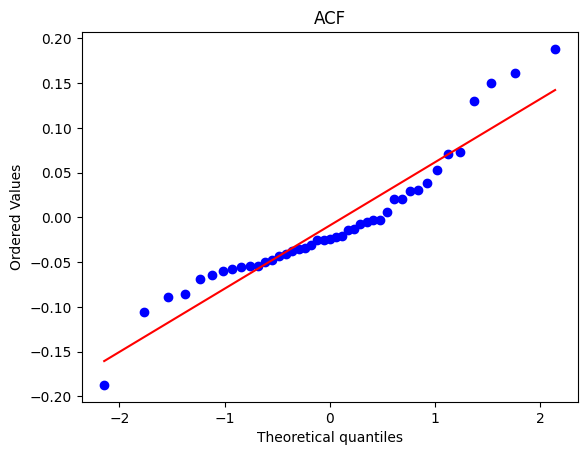

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


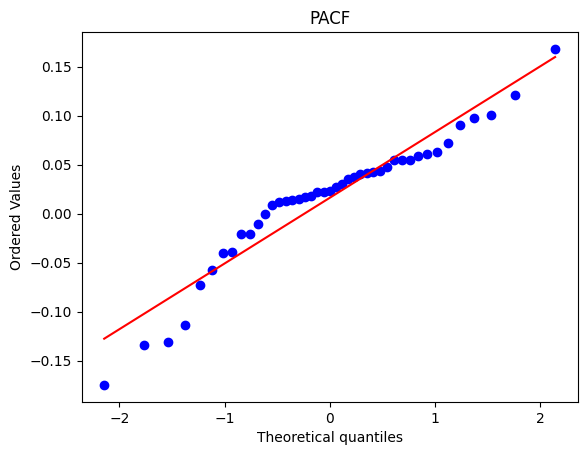

In [22]:
AS = [1, 1] + [0]*34 + [1,1]
CS = 0
# CS = [1] + [0]*35 + [1]
model_full_tr, ACF_full_tr, PACF_full_tr = analyzeARMA(transformed_EG_nvdi, A=AS, C=CS, noLags=80, return_val=True, remove=True)

Since the ACF and PACF is not normally distributed, the whiteness tests cannot be trusted, and since we observe a value very close to the significant level for the Monti test, along with the cumulative periodogram, we can say that the residuals are more or less white.

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.892(±0.026)·z⁻¹ - 0.2419(±0.0523)·z⁻³⁶ + 0.1335(±0.0525)·z⁻³⁷

Polynomial orders: nA = 37
Number of free coefficients: 3
Fit to estimation data (NRMSE): 52.78%
FPE : 11.654  MSE : 11.457
AIC : 1863.328   BIC : 1874.919



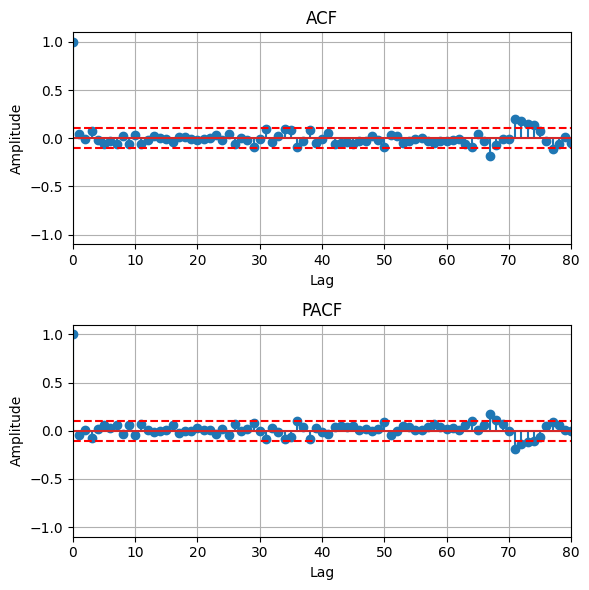

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 9.86 < 31.41)
  McLeod-Li test:        False (white if 56.98 < 31.41)
  Monti test:            True (white if 11.78 < 31.41)
  Sign change test:      True (white if 0.54 in [0.45,0.55])


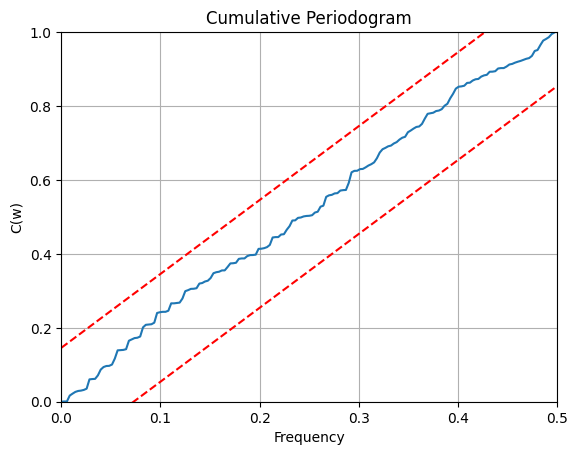

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


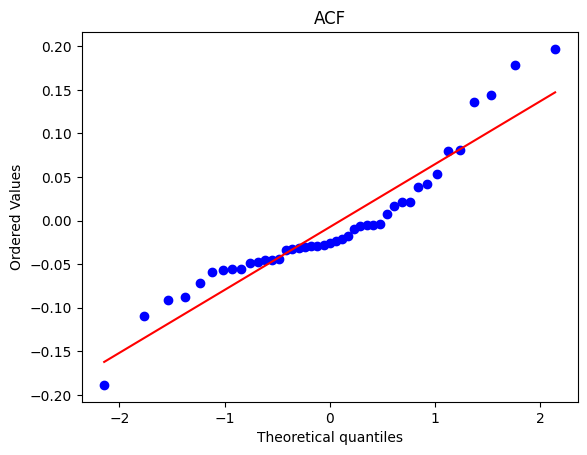

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


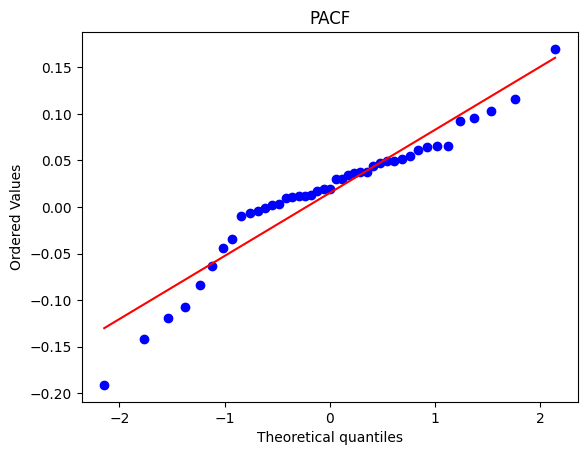

In [23]:
# Modelling with the same parameters for untransformed data. Note that I have already checked for the optimal 
# parameters the same way for the transformed data.
AS = [1, 1] + [0]*34 + [1,1]
# CS = [1] + [0]*35 + [1]
CS = 0
model_full, ACF_full, PACF_full = analyzeARMA(EG_nvdi, A=AS, C=CS, noLags=80, return_val=True, remove=True)

Hence, we take our estimated ARMA coefficients and form our prediction in our validation data.

### Prediction on Validation data

The naive predictor that we will be using here would be the rain data from the latest year ago, or 36 indexes away. 

Estimate noise variance for naive predictor is 21.4053


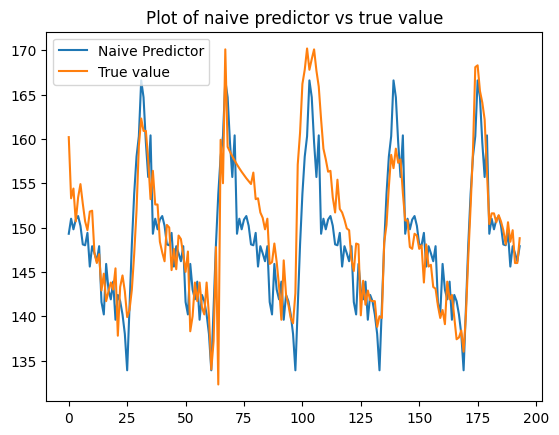

In [24]:
y = EG_validation['nvdi'].values
n = int(np.ceil(len(y)/36))
naive_pred = EG_nvdi[-36:].tolist()*n
naive_pred = naive_pred[:len(y)-len(naive_pred)]
pred_error = y[len(y)-len(naive_pred):] - np.array(naive_pred)
noise_var = np.var(pred_error)
print(f'Estimate noise variance for naive predictor is {round(noise_var,4)}')
plt.plot(naive_pred, label='Naive Predictor')
plt.plot(y, label='True value')
plt.title('Plot of naive predictor vs true value')
plt.legend()
plt.show()

Estimated noise variance for 1-step prediction is 17.582731
Estimated standardized noise variance for 1-step prediction is 0.276315
Estimated noise variance for 7-step prediction is 62.440378
Estimated standardized noise variance for 7-step prediction is 0.981259


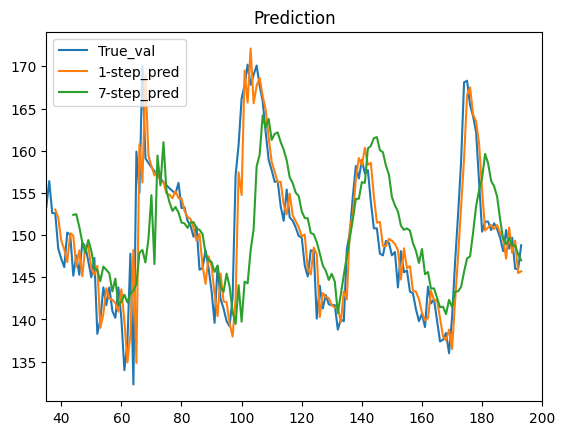

In [25]:
# Transformed prediction
yhatk, noisek = pred_k(y=y, k=[1,7], A=model_full_tr.A, C=model_full_tr.C, transform=lambda x: (x**-1), inv_transform=lambda x: (x**-1))
plt.xlim(35,200)
plt.show()

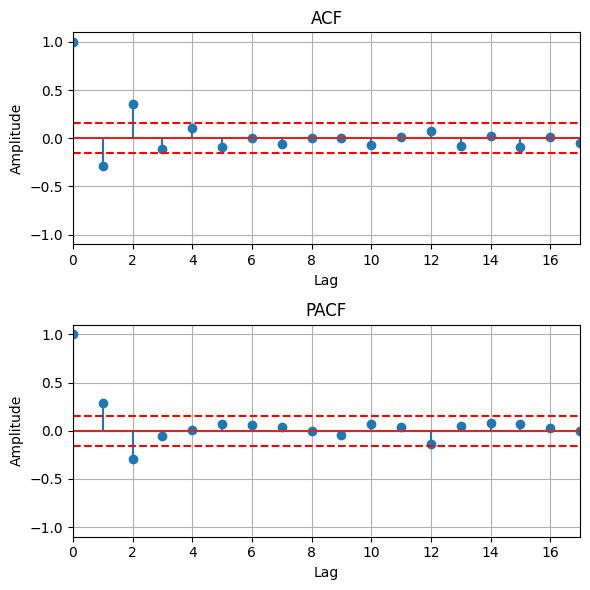

In [26]:
modelling.plotACFnPACF(noisek[1])

Here, we would expect to see a white noise, it is not clear whether the values in lag 1 or 2 are significant or not as they are barely above the confidence interval. 

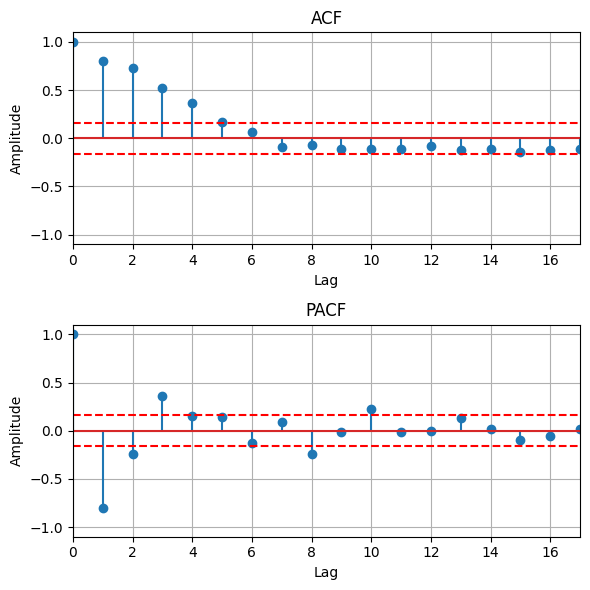

In [27]:
modelling.plotACFnPACF(noisek[7])

Here we expect to see an MA(6), however it can be argued that it is an MA(4). This error might be due to the transformation of the data.

Estimated noise variance for 1-step prediction is 17.325861
Estimated standardized noise variance for 1-step prediction is 0.272278
Estimated noise variance for 7-step prediction is 60.39414
Estimated standardized noise variance for 7-step prediction is 0.949102


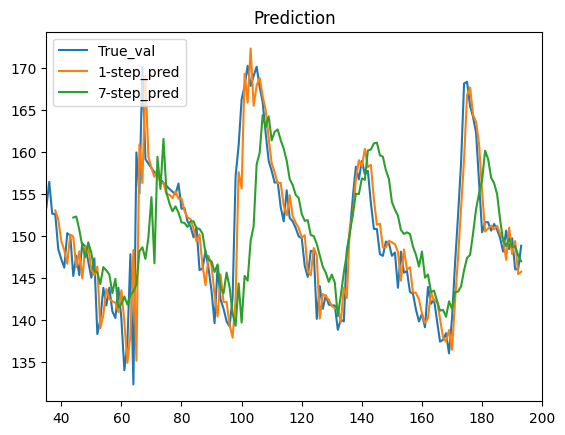

In [28]:
# Untransformed data
y = EG_validation['nvdi'].values
yhat_k, noise_k = pred_k(y=y, k=[1,7], A=model_full.A, C=model_full.C)
plt.xlim(35,200)
plt.show()

Here we observe a smaller noise variance is observed for the untransformed data. We also observe that the transformed and untransformed prediction has a smaller noise variance than the naive prediction.

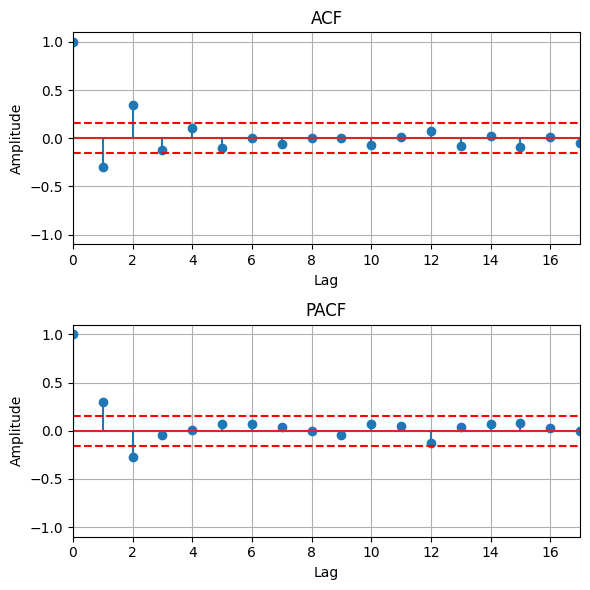

In [29]:
modelling.plotACFnPACF(noise_k[1])

With similar arguments as in the transformed case.

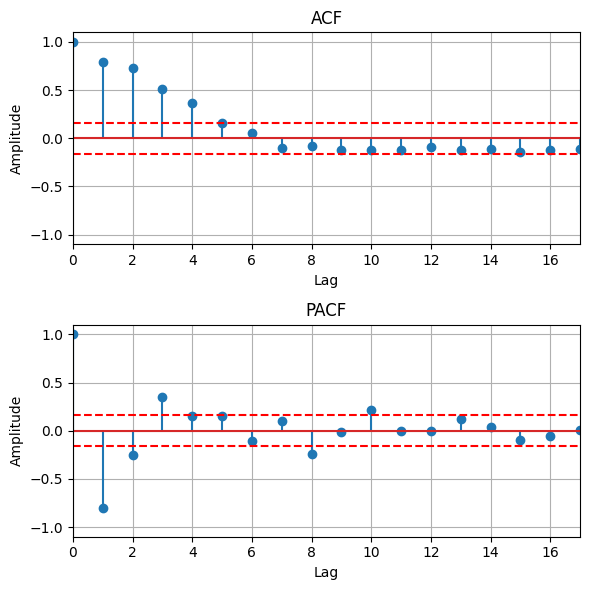

In [30]:
modelling.plotACFnPACF(noise_k[7])

The ACF here looks more like an MA(5) than the transformed version.

### Prediction on Test data

Estimate noise variance for naive predictor is 53.8926


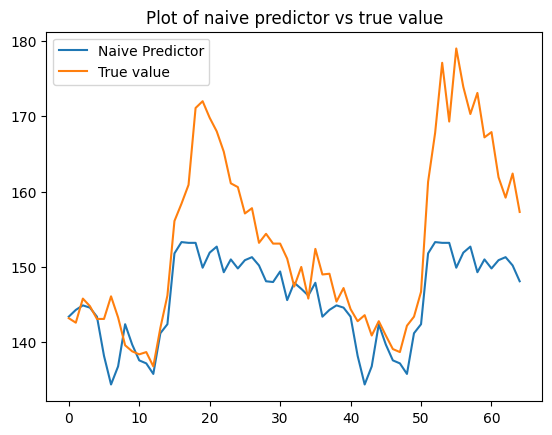

In [31]:
# Naive prediction of Test data
y_test = EG_testing['nvdi'].values
k = n_validation%36
n = int(np.ceil(len(y_test)/36))
naive_pred = EG_nvdi[-72+k:-36+k].tolist()*n
naive_pred = naive_pred[:len(y_test)-len(naive_pred)]
pred_error = y_test[len(y_test)-len(naive_pred):] - np.array(naive_pred)
noise_var = np.var(pred_error)
print(f'Estimate noise variance for naive predictor is {round(noise_var,4)}')
plt.plot(naive_pred, label='Naive Predictor')
plt.plot(y_test, label='True value')
plt.title('Plot of naive predictor vs true value')
plt.legend()
plt.show()

Estimated noise variance for 1-step prediction is 22.854753
Estimated standardized noise variance for 1-step prediction is 0.172126
Estimated noise variance for 7-step prediction is 115.334222
Estimated standardized noise variance for 7-step prediction is 0.868617


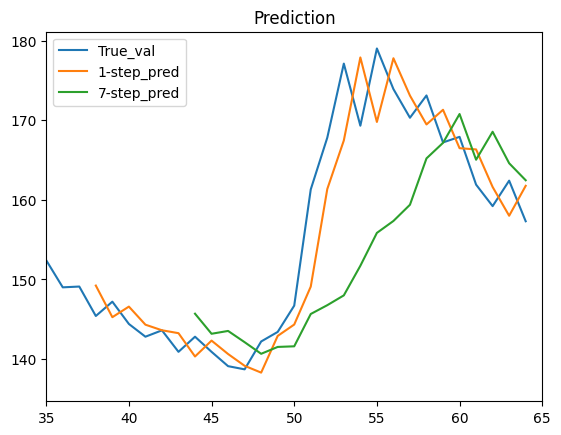

In [32]:
# Untransformed data
y_test = EG_testing['nvdi'].values
yhat_test, noise_test = pred_k(y=y_test, k=[1,7], A=model_full.A, C=model_full.C)
plt.xlim(35,65)
plt.show()

The 1-step and 7-step prediction here looks as expected. We

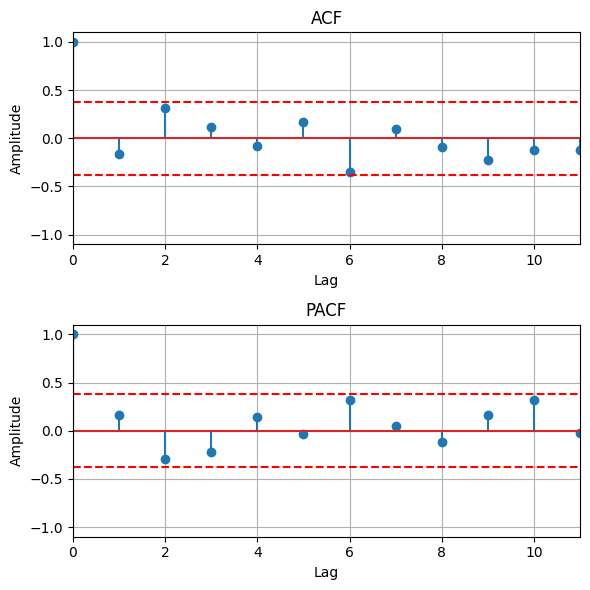

In [33]:
modelling.plotACFnPACF(noise_test[1])

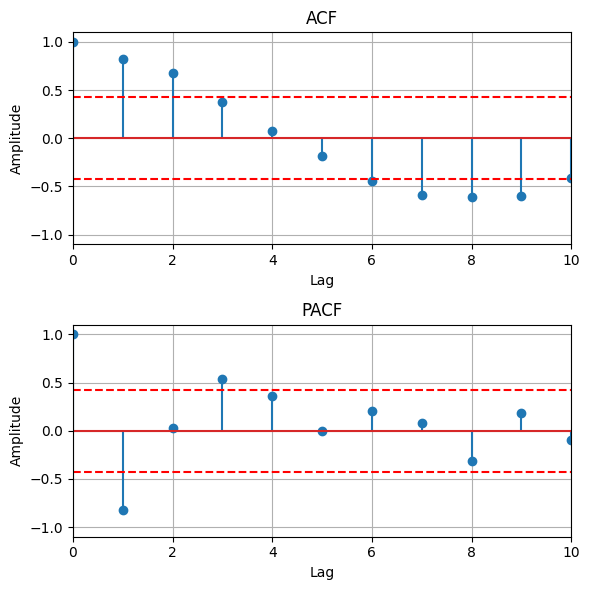

In [34]:
modelling.plotACFnPACF(noise_test[7])

### Test prediction on simulated data

Estimated noise variance for 1-step prediction is 0.375095
Estimated standardized noise variance for 1-step prediction is 0.03346
Estimated noise variance for 7-step prediction is 8.373212
Estimated standardized noise variance for 7-step prediction is 0.746931


(400.0, 500.0)

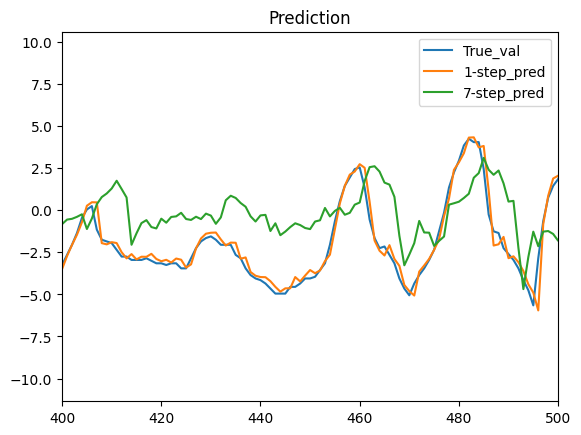

In [35]:
svedala = analysis.mat2np('./data/svedala.mat')
A = [1, -1.79, 0.84] ;
C = [1, -0.18, -0.11 ] ;
k = [1,7]
yhat_k, noise_var = pred_k(y=svedala, A=A,C=C,k=k)
plt.xlim(400,500)
# plt.xlim(200,400)

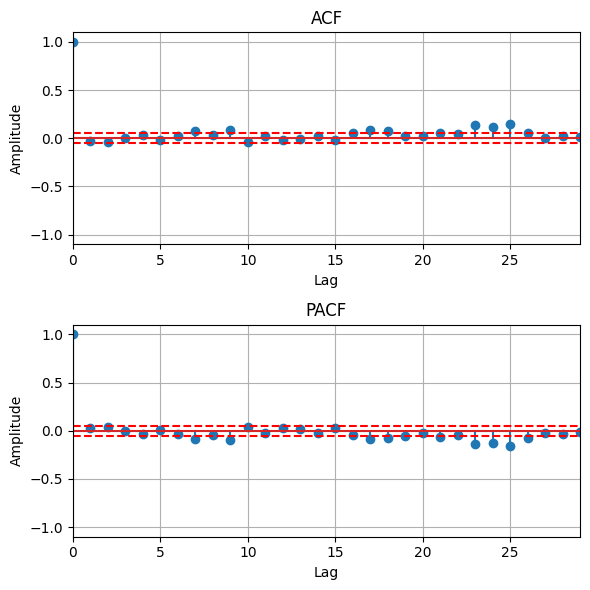

In [36]:
modelling.plotACFnPACF(noise_var[1])

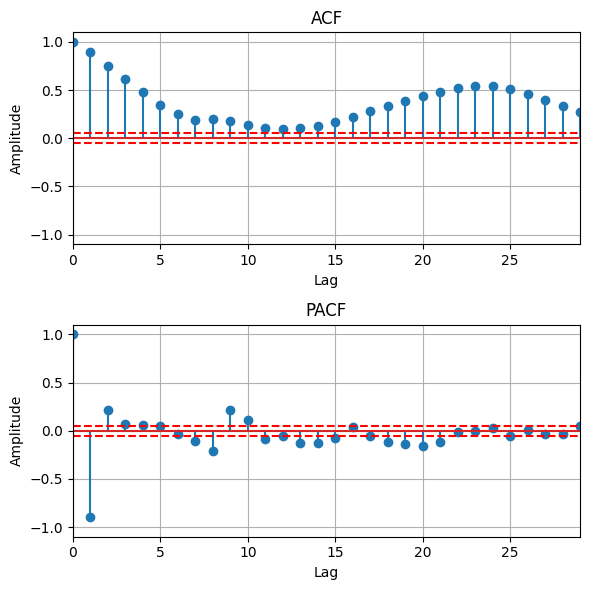

In [37]:
modelling.plotACFnPACF(noise_var[7])

## With precipitation

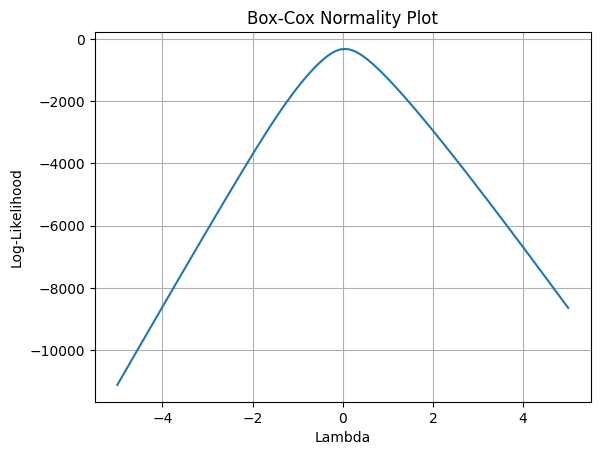

Max Lambda = 0.0458900323376866.
ln(y) could be an appropriate transformation.


In [38]:
max_lambda = analysis.box_cox(EG_modelling['estimated_rain'].values, lamRange=[-5,5])

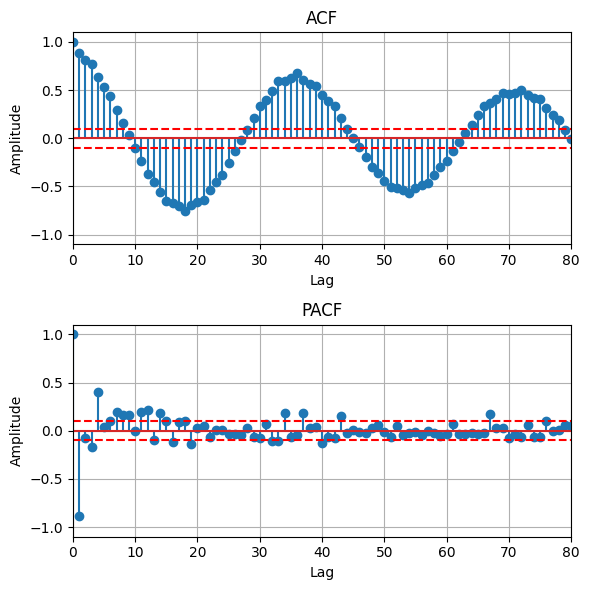

In [39]:
x = np.log(EG_modelling['estimated_rain'].values)
analysis.plotACFnPACF(x, noLags=80)

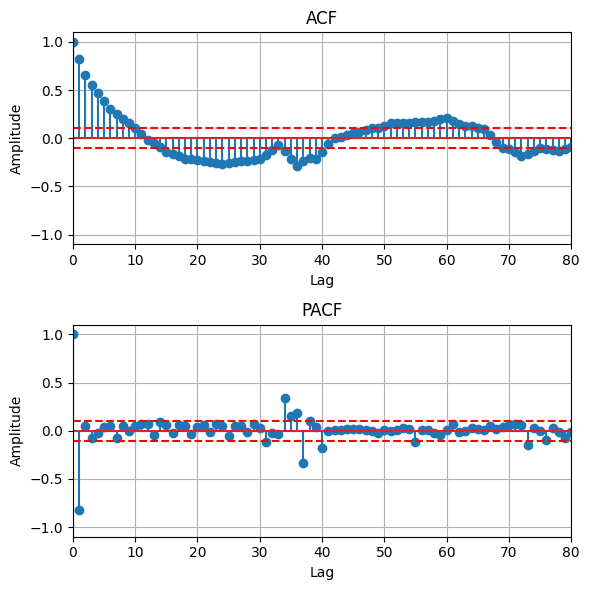

In [40]:
AS = [1] + [0]*35 + [-1]
x_nabla36 = modelling.filter(AS,1,x, remove=True)
modelling.plotACFnPACF(x_nabla36, noLags=80)

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.8225(±0.0302)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 43.17%
FPE : 2.241  MSE : 2.228
AIC : 1282.958   BIC : 1286.822



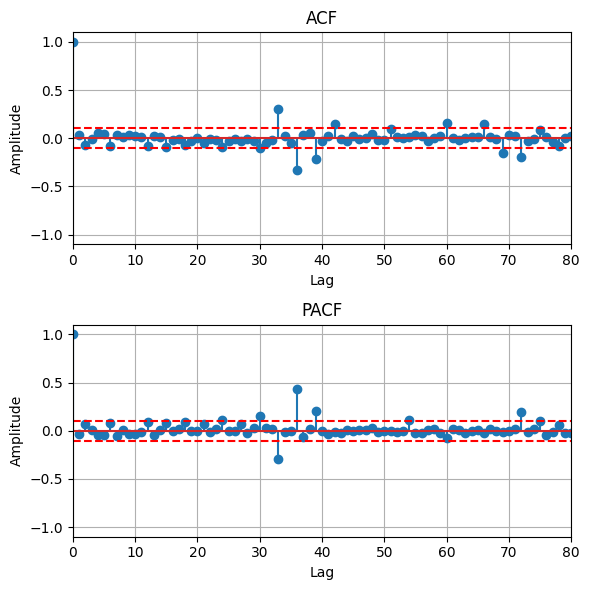

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 15.33 < 31.41)
  McLeod-Li test:        False (white if 92.48 < 31.41)
  Monti test:            True (white if 17.54 < 31.41)
  Sign change test:      False (white if 0.43 in [0.45,0.55])


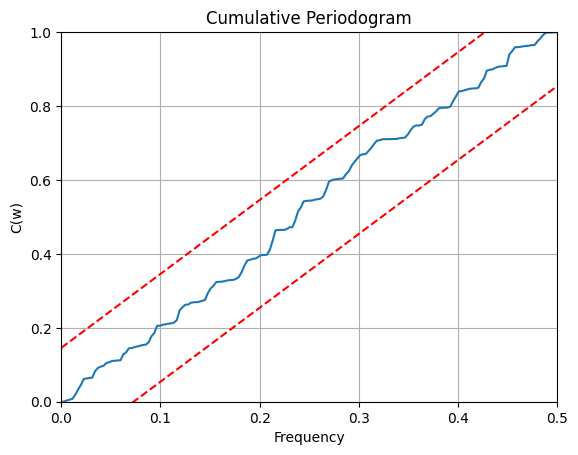

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


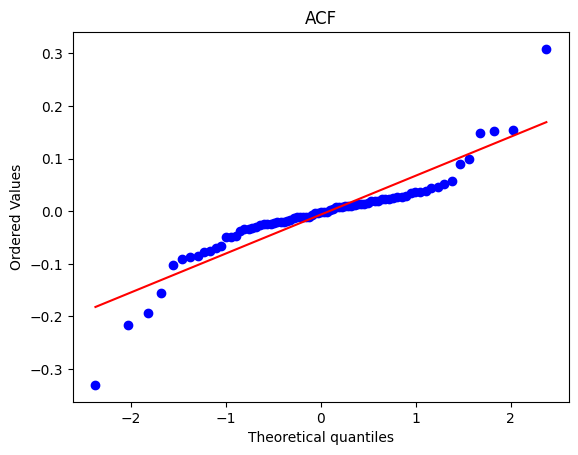

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


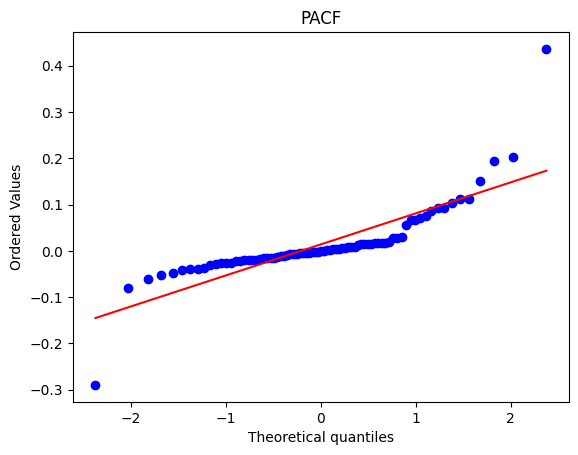

In [41]:
# Here we try to model an AR(1)
AS = [1, 1]
model_x_ar, ACF_x_ar, PACF_x_ar = analyzeARMA(x_nabla36, A=AS,noLags=80, return_val=True)

Discrete-time MA model: y(t) = C(z)e(t)

C(z) = 1.0 + 0.1232(±0.0428)·z⁻³³ - 0.6603(±0.0417)·z⁻³⁶ - 0.1719(±0.0429)·z⁻³⁹

Polynomial orders: nC = 39
Number of free coefficients: 3
Fit to estimation data (NRMSE): 17.33%
FPE : 1.546  MSE : 1.523
AIC : 1152.953   BIC : 1164.544



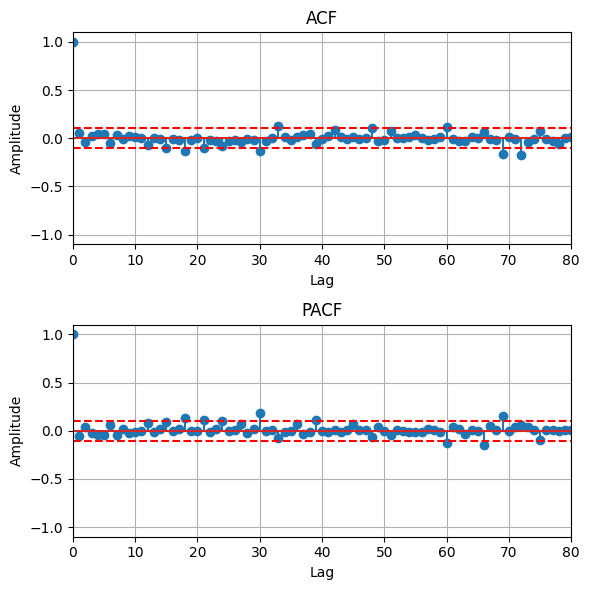

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 16.69 < 31.41)
  McLeod-Li test:        False (white if 75.25 < 31.41)
  Monti test:            True (white if 17.89 < 31.41)
  Sign change test:      True (white if 0.46 in [0.45,0.55])


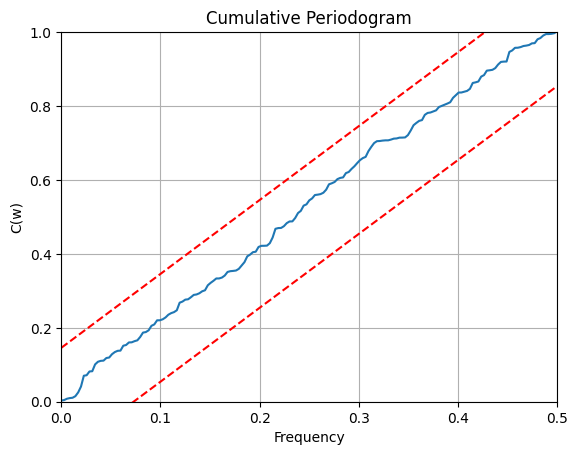

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


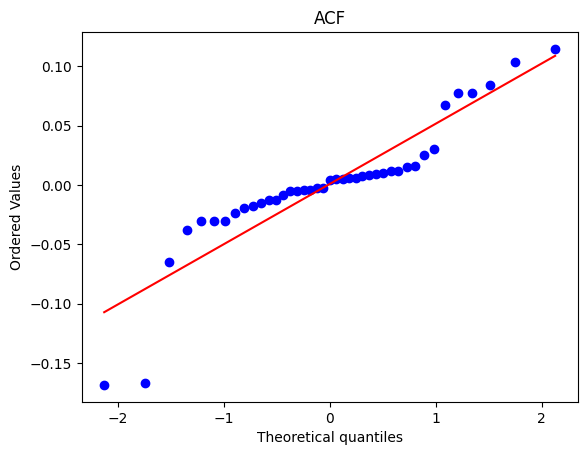

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


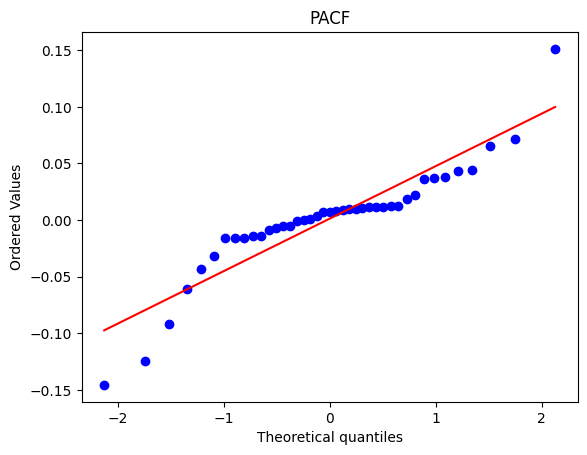

In [42]:
# Including a c_33 and c_36
CS = [1] + [0]*32 + [1, 0,0 ,1,0,0,1]
# CS = [1] + [0]*35 + [1]
model_x_ma, ACF_x_ma, PACF_x_ma = analyzeARMA(model_x_ar.resid, C=CS,noLags=80, return_val=True)

Seems reasonable. Now re-estimating all the parameters together

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.8508(±0.0282)·z⁻¹ - 0.8454(±0.0452)·z⁻³⁶ + 0.713(±0.0473)·z⁻³⁷
C(z) = 1.0 + 0.2332(±0.0445)·z⁻³³ - 0.4811(±0.0683)·z⁻³⁶

Polynomial orders: nA = 37    nC = 36
Number of free coefficients: 5
Fit to estimation data (NRMSE): 67.25%
FPE : 1.584  MSE : 1.54
AIC : 1160.818   BIC : 1180.136



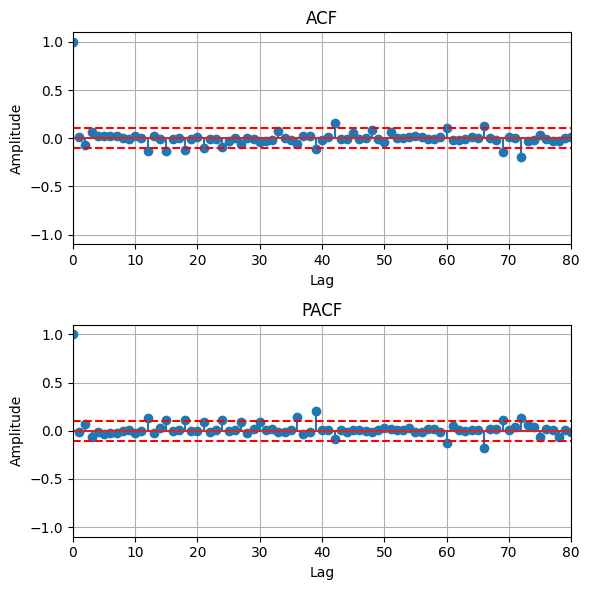

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 23.22 < 31.41)
  McLeod-Li test:        False (white if 71.19 < 31.41)
  Monti test:            True (white if 20.78 < 31.41)
  Sign change test:      False (white if 0.43 in [0.45,0.55])


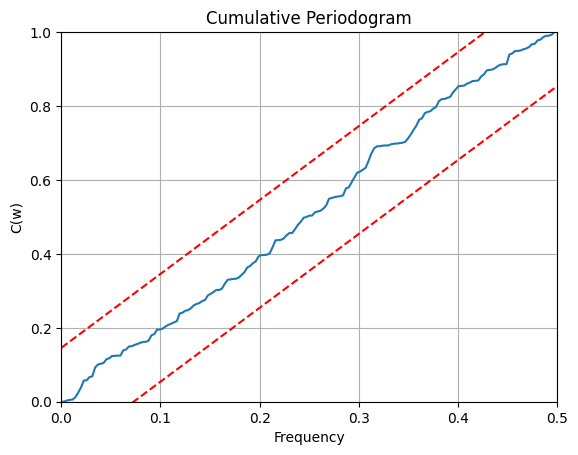

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


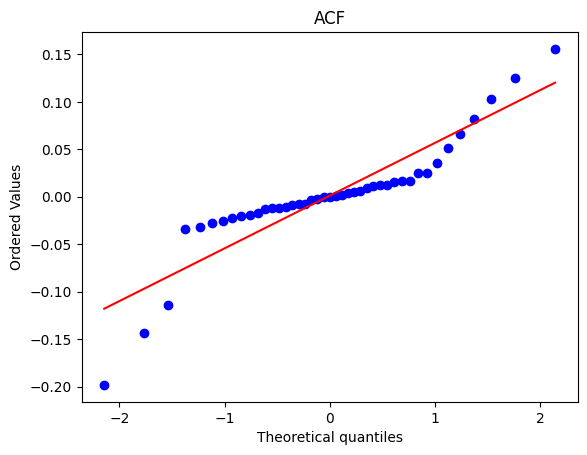

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


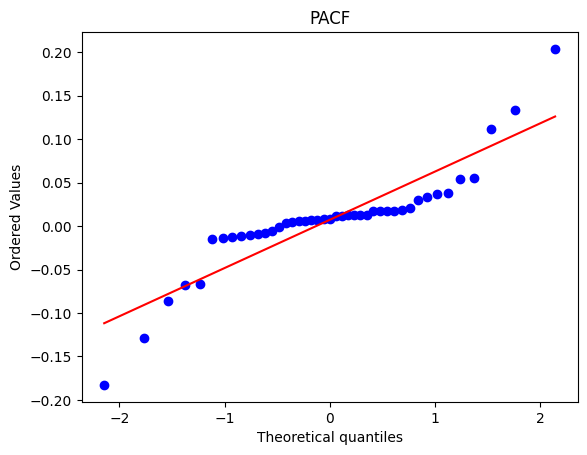

In [43]:
AS = np.convolve([1, 1], [1]  + [0]*35 + [-1])
# AS = [1,1] + [0]*34 + [1]
CS = [1] + [0]*32 + [1, 0,0 ,1] # maybe c42?
model_x_full, ACF_x_full, PACF_x_full = analyzeARMA(x, A=AS, C=CS, noLags=80, return_val=True, remove=True)

Very reasonable

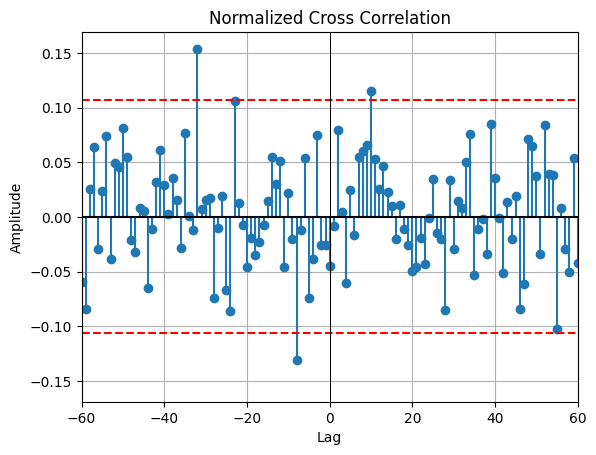

In [44]:
# Pre-whiten y_t
y = EG_modelling['nvdi'].values
est_A3 = model_x_full.A
est_C3 = model_x_full.C
w_t = model_x_full.resid
M = 80
eps_t = modelling.filter(est_A3, est_C3, y, remove=True)
corr = analysis.ccf(w_t, eps_t, numLags=60, plotIt=False)
analysis.ccf(w_t, eps_t, numLags=60)

Here, d=10 or 55, s=0, r=0 or 2 looks reasonable

Discrete-time BJ model: y(t) = [B(z)/F(z)]x(t) + e(t)

B(z) = -0.1443(±0.0145)·z⁻¹⁰
F(z) = 1.0 - 1.9032(±0.0104)·z⁻¹ + 0.9035(±0.0104)·z⁻²

Polynomial orders: nB = 10    nF = 2
Number of free coefficients: 3
Fit to estimation data (NRMSE): -395.76%
FPE : 1204.098  MSE : 1263.142
AIC : 3788.13   BIC : 3799.943

mean of et: 8.829298951412238


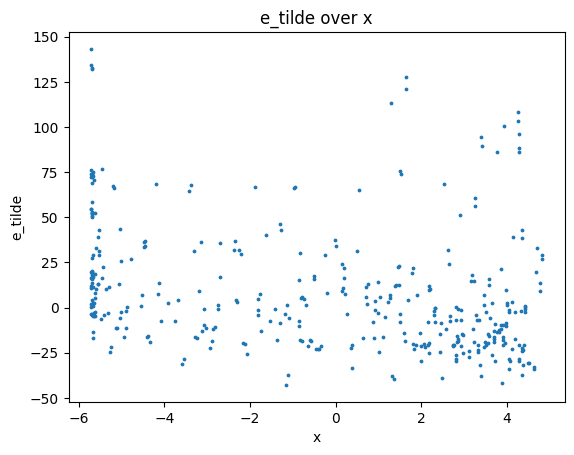

In [45]:
# Estimate 
x = np.log(EG_modelling['estimated_rain'].values)
# x = EG_modelling['estimated_rain'].values
A2 = 2
B = np.convolve([0]*10 +[1], [1])
# B = [0]*55 + [1]
model_x = modelling.PEM( y=y,x=x,A=0,B=B,F=A2)
model_x.set_free_params(B_free=B)
model_fitted_x = model_x.fit(method='LS', bh=False)
model_fitted_x.summary()
e_tilde = model_fitted_x.resid
print(f'mean of et: {np.mean(e_tilde)}')
plt.scatter(x[len(x)-len(e_tilde):], e_tilde, s=3)
plt.title('e_tilde over x')
plt.xlabel('x')
plt.ylabel('e_tilde')
plt.show()

Discrete-time BJ model: y(t) = [B(z)/F(z)]x(t) + e(t)

B(z) = -2.4732(±0.3167)·z⁻⁵⁵
F(z) = 1.0 - 0.1292(±0.2343)·z⁻¹ - 0.867(±0.2338)·z⁻²

Polynomial orders: nB = 55    nF = 2
Number of free coefficients: 3
Fit to estimation data (NRMSE): -420.75%
FPE : 1315.036  MSE : 1393.695
AIC : 3371.915   BIC : 3383.349

mean of et: 10.10310090936501


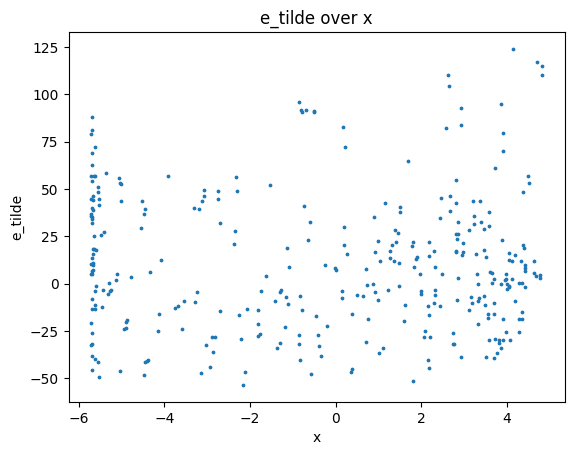

In [46]:
# Estimate 
A2 = 2
x = np.log(EG_modelling['estimated_rain'].values)
B = [0]*55 +[1]
model_x = modelling.PEM( y=y,x=x,A=0,B=B,F=A2)
model_x.set_free_params(B_free=B)
model_fitted_x = model_x.fit(method='LS', bh=False)
model_fitted_x.summary()
e_tilde = model_fitted_x.resid
print(f'mean of et: {np.mean(e_tilde)}')
plt.scatter(x[len(x)-len(e_tilde):], e_tilde, s=3)
plt.title('e_tilde over x')
plt.xlabel('x')
plt.ylabel('e_tilde')
plt.show()

d= 10, s=0, r=2 looks reasonable results in a more uncorrelated e_tilde over x, and a closer mean to 0. Hence, we will use this value

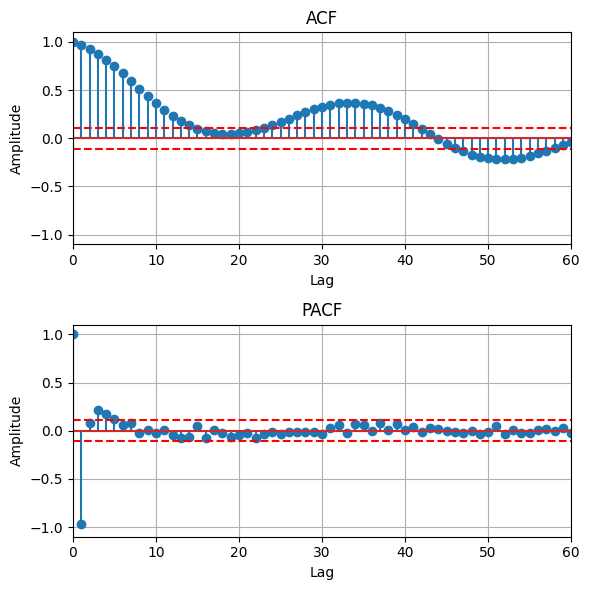

In [47]:
analysis.plotACFnPACF(e_tilde, noLags=60)

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.9705(±0.0092)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 82.54%
FPE : 39.599  MSE : 39.396
AIC : 2170.347   BIC : 2174.155



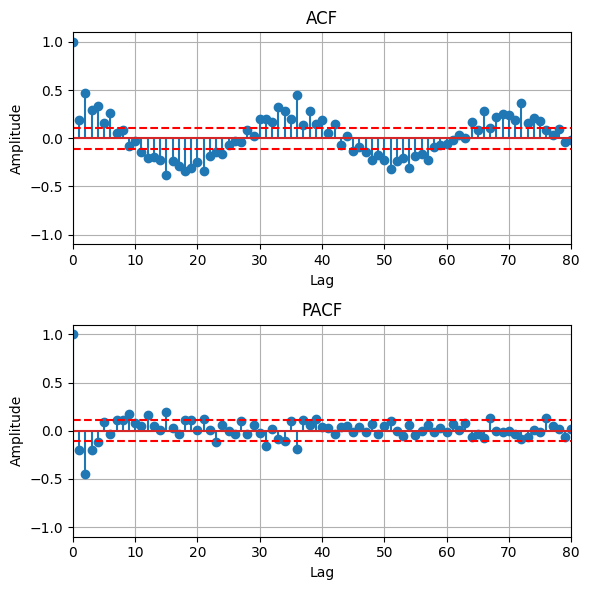

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 441.22 < 31.41)
  McLeod-Li test:        False (white if 52.50 < 31.41)
  Monti test:            False (white if 159.06 < 31.41)
  Sign change test:      False (white if 0.38 in [0.45,0.55])


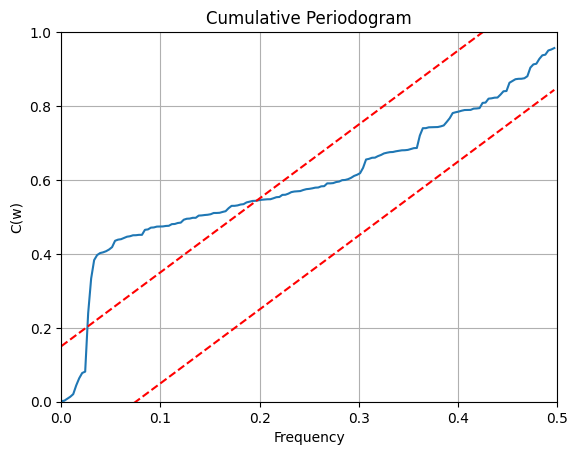

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


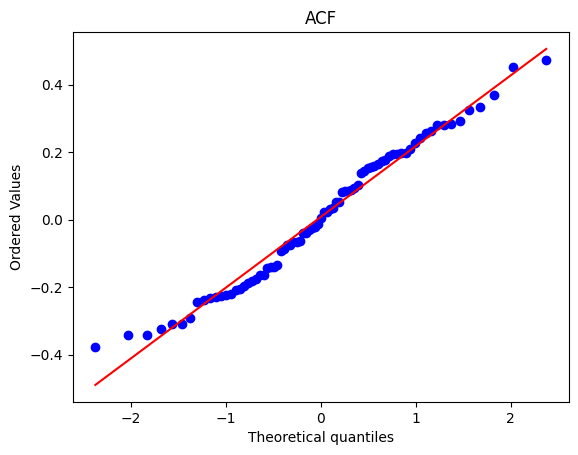

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


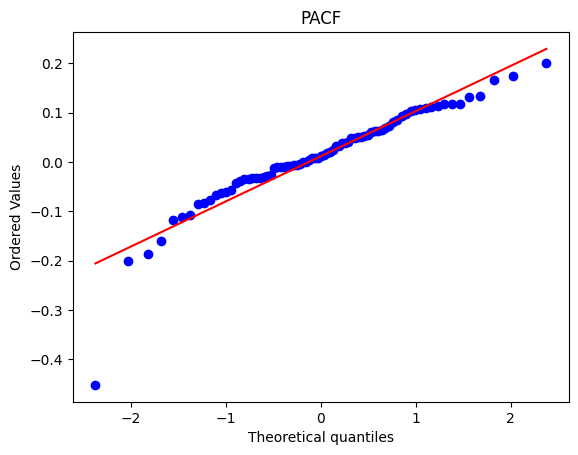

In [48]:
# Here we try to model an AR(1)
AS = [1, 1]
model_et_ar, ACF_et_ar, PACF_et_ar = analyzeARMA(e_tilde, A=AS,noLags=80, return_val=True)

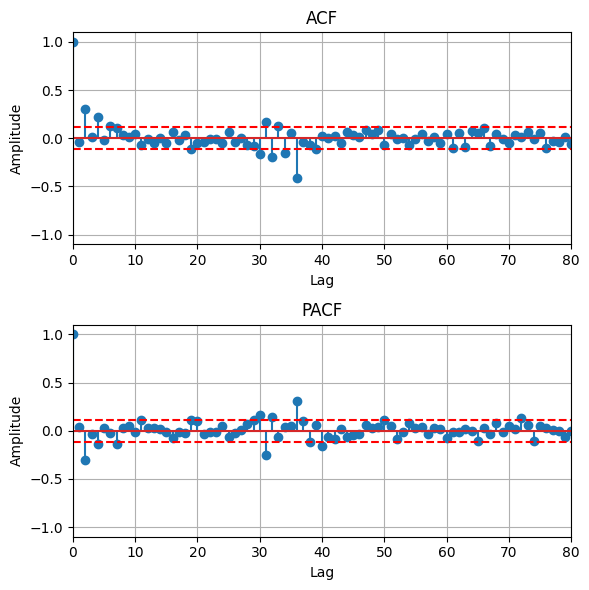

In [49]:
AS = [1] + [0]*35 + [-1]
et_nabla36 = modelling.filter(AS,1,model_et_ar.resid, remove=True)
modelling.plotACFnPACF(et_nabla36, noLags=80)

Discrete-time MA model: y(t) = C(z)e(t)

C(z) = 1.0 + 0.0295(±0.0475)·z⁻³ - 0.6633(±0.0517)·z⁻³⁶

Polynomial orders: nC = 36
Number of free coefficients: 2
Fit to estimation data (NRMSE): 14.59%
FPE : 28.665  MSE : 28.347
AIC : 1840.169   BIC : 1847.556



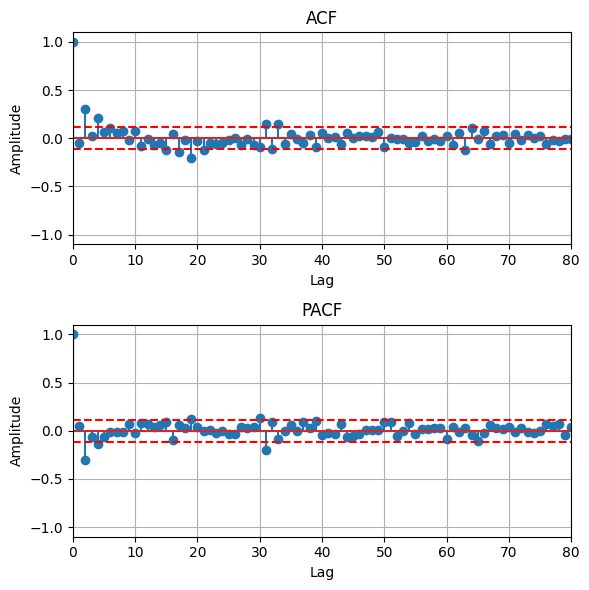

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 81.90 < 31.41)
  McLeod-Li test:        False (white if 127.84 < 31.41)
  Monti test:            False (white if 55.85 < 31.41)
  Sign change test:      True (white if 0.55 in [0.44,0.56])


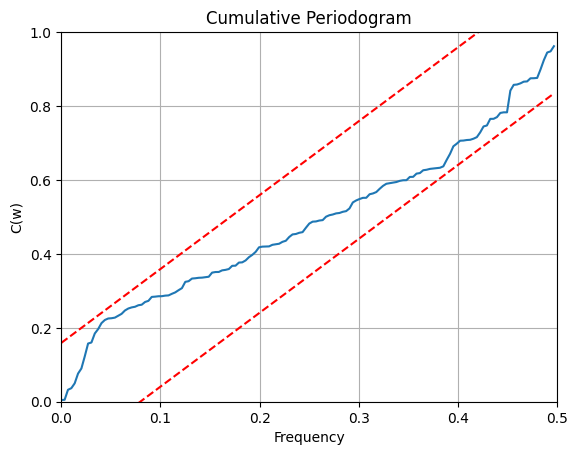

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


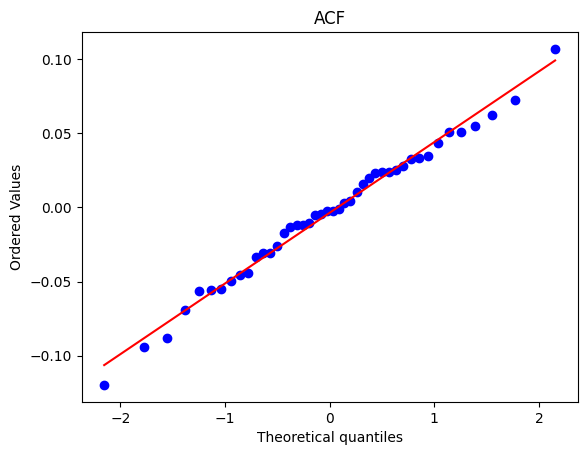

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


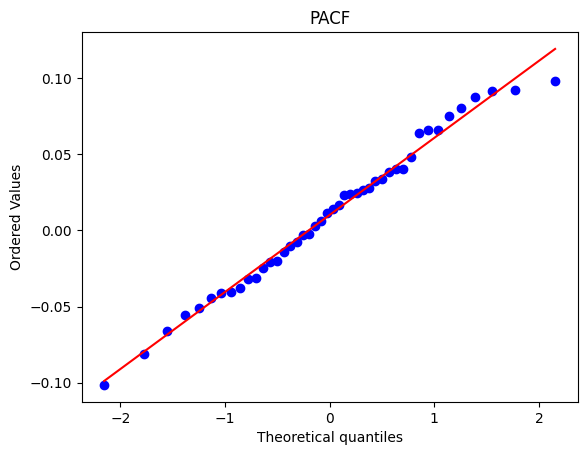

In [50]:
# Including a c_3 and c_36
CS = [1,0,0,1] + [0]*32 + [1]
# CS = [1] + [0]*35 + [1]
model_et_ma, ACF_et_ma, PACF_et_ma = analyzeARMA(et_nabla36, C=CS,noLags=80, return_val=True)

Reasonable

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.972(±0.0139)·z⁻¹ - 0.6967(±0.059)·z⁻³⁶ + 0.6966(±0.0577)·z⁻³⁷
C(z) = 1.0 + 0.0542(±0.0584)·z⁻³ - 0.2961(±0.0806)·z⁻³⁶

Polynomial orders: nA = 37    nC = 36
Number of free coefficients: 5
Fit to estimation data (NRMSE): 85.48%
FPE : 28.167  MSE : 27.234
AIC : 1834.281   BIC : 1852.749



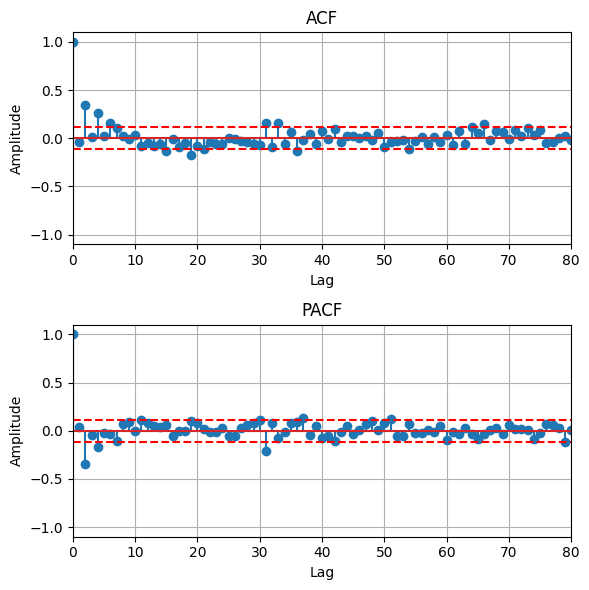

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 94.62 < 31.41)
  McLeod-Li test:        False (white if 100.28 < 31.41)
  Monti test:            False (white if 67.04 < 31.41)
  Sign change test:      True (white if 0.55 in [0.44,0.56])


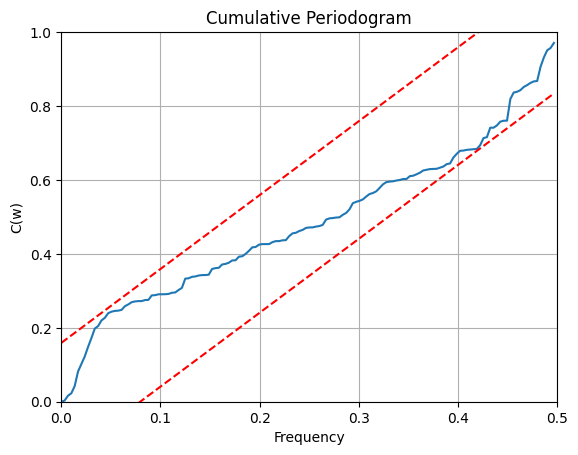

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


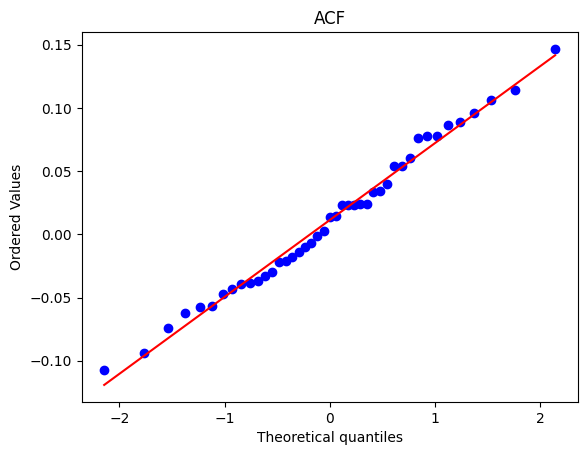

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


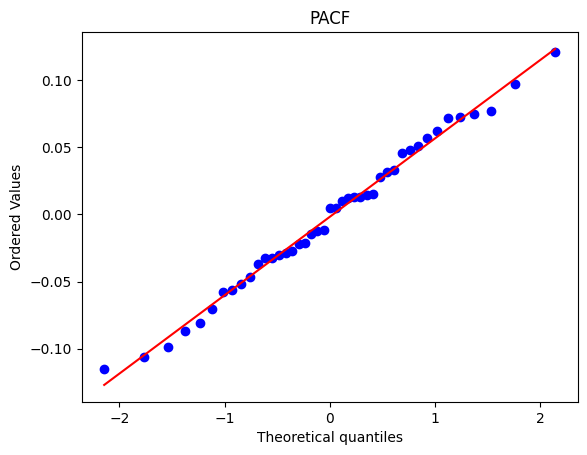

In [51]:
# AS = np.convolve([1, 1], [1]  + [0]*35 + [-1])
# CS = [1] + [0]*32 + [1, 0,0 ,1]

AS = np.convolve([1, 1], [1]  + [0]*35 + [-1])
CS = [1, 0, 0,1] + [0]*32 + [1]
# CS = [1] + [0]*35 + [1]
model_et_full, ACF_et_full, PACF_et_full = analyzeARMA(e_tilde, A=AS, C=CS, noLags=80, return_val=True, remove=True)

The parameter seems statistically significant as 0 is not within their confidence intervals. From the normality test of ACF and PACF, we can trust our tests more. From the whiteness test and periodogram, we can assume that the residuals are white.

Discrete-time BJ model: y(t) = [B(z)/F(z)]x(t) + [C(z)/D(z)]e(t)

B(z) = 0.0356(±0.0237)·z⁻¹⁰
C(z) = 1.0 + 0.0814(±0.0509)·z⁻³ - 0.0372(±0.0378)·z⁻³⁶
D(z) = 1.0 - 0.8802(±0.0278)·z⁻¹ - 0.2905(±0.0613)·z⁻³⁶ + 0.17(±0.0626)·z⁻³⁷
F(z) = 1.0 + 1.1054(±0.0087)·z⁻¹ + 0.9931(±0.0102)·z⁻²

Polynomial orders: nB = 10    nC = 36    nD = 37    nF = 2
Number of free coefficients: 8
Fit to estimation data (NRMSE): 53.29%
FPE : 11.733  MSE : 11.212
AIC : 1865.709   BIC : 1896.619



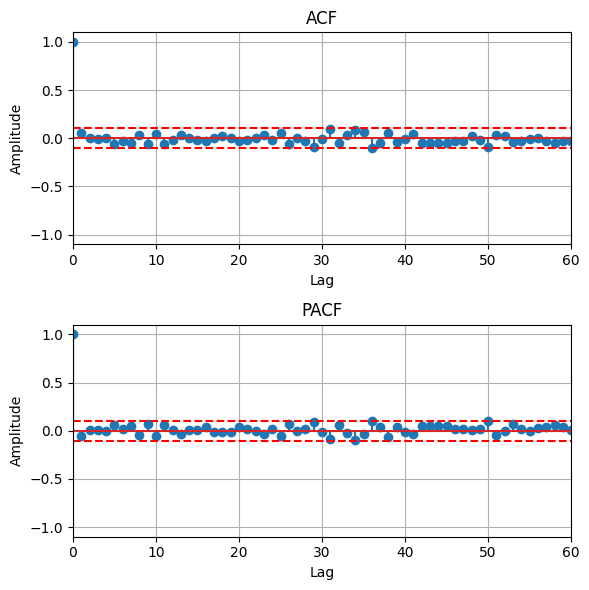

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 8.41 < 31.41)
  McLeod-Li test:        False (white if 67.52 < 31.41)
  Monti test:            True (white if 9.78 < 31.41)
  Sign change test:      True (white if 0.55 in [0.45,0.55])


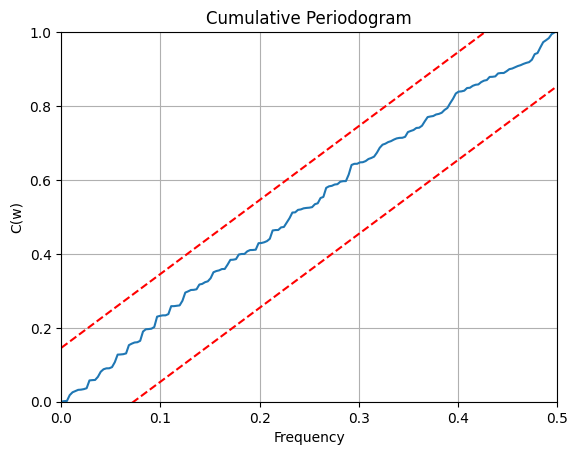

In [52]:
A1 = np.convolve([1, 1], [1]  + [0]*35 + [-1])
A2 = [1,1,1]
B=1
C= [1, 0, 0,1] + [0]*32 + [1]
x = np.log(EG_modelling['estimated_rain'].values)
y = EG_modelling['nvdi'].values
BJ_model = modelling.estimateBJ(y,x,B=B, d=10, A2=A2,C1=C, A1=A1, C1_free=C, A1_free=A1, A2_free=A2,B_free=B,noLags=60)

The Box-Jenkins model seems to be evaluating roughly 54% of the data which is decent. The residuals passes the monti-test and the cumulative periodgram indicating that it is roughly white.

### Prediction on Validation data

In [ ]:
y_v = EG_validation['nvdi']
x_v = EG_validation['estimated_rain']
k=1
KA = np.convolve(final_model_fitted.D, final_model_fitted.F)
KB = np.convolve(final_model_fitted.D, final_model_fitted.B)
KC = np.convolve(final_model_fitted.F, final_model_fitted.C)
F1, G1 = modelling.polydiv(KC, KA, k)
BF1 = np.convolve(KB, F1)
Fhat1, Ghat1 = modelling.polydiv(BF1, KC, k)
xhat1 = modelling.filter(G1, C, x_v)

yhat1 = modelling.filter(Ghat3, C, sturup) + modelling.filter(G3, C, svedala) + modelling.filter(Fhat3, [1],sturup)
remove = max(len(Fhat3), len(Ghat3), len(G3), 1)
yhat1 = yhat1[remove:]

The use of rain as an input did not really improve the prediction as the variance of the noise is roughly the same. Which makes sense as the parameter values for the C polynomial is very close to 0. The variance explained by the rain as an input is not much.

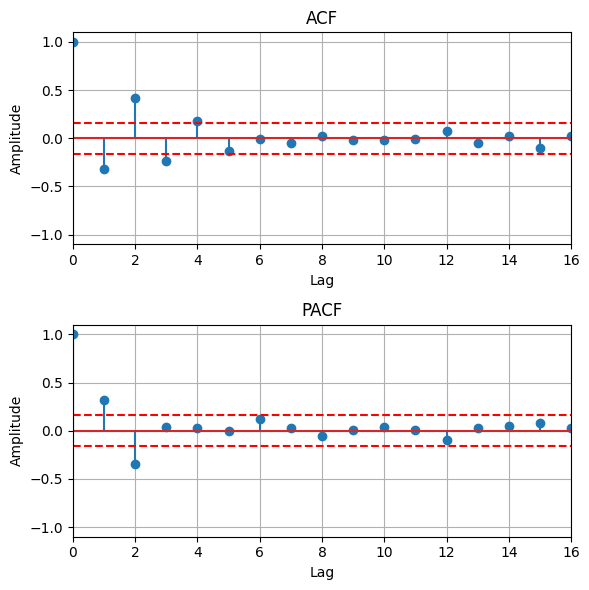

In [54]:
analysis.plotACFnPACF(noise[1])

Here, we observe a similar case as in the analysis without percipitation.

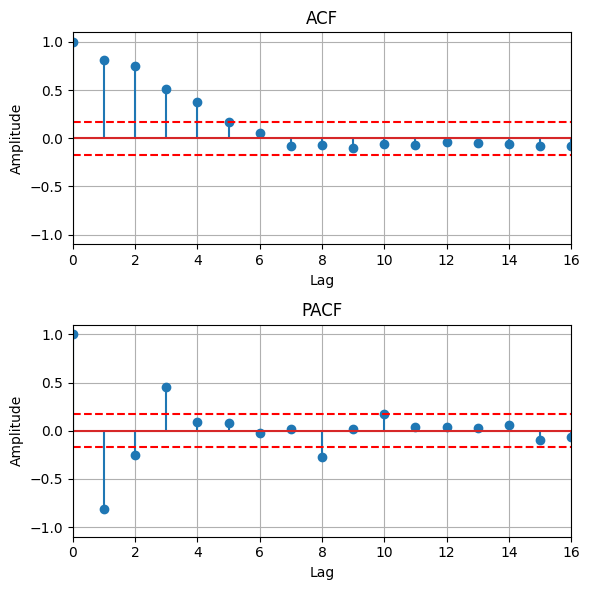

In [55]:
analysis.plotACFnPACF(noise[7])

An MA(5) can be observed here, while we expect an MA(6). This still looks pretty good.

In [56]:
y_v = EG_testing['nvdi'].values
x_v = EG_testing['estimated_rain'].values
k=[1,7]
KA = np.convolve(BJ_model.D, BJ_model.F)
KB = np.convolve(BJ_model.D, BJ_model.B)
KC = np.convolve(BJ_model.F, BJ_model.C)
yhat_1_df, noise = pred_k(y_v,x=x_v, A=KA, B=KB, C=KC, k=k, x_transform=lambda x: np.log(x), plot=False)

Estimated noise variance for 1-step prediction is 33.2902
Estimated standardized noise variance for 1-step prediction is 0.250719
Total variance: 132.7791
Variance explained by x: 0.5938
Estimated noise variance for 7-step prediction is 7.305649
Estimated standardized noise variance for 7-step prediction is 0.055021
Total variance: 132.7791
Variance explained by x: 0.4296


# Time-varying model for El-Geneina.

The variance of predicted noise: 7.181233


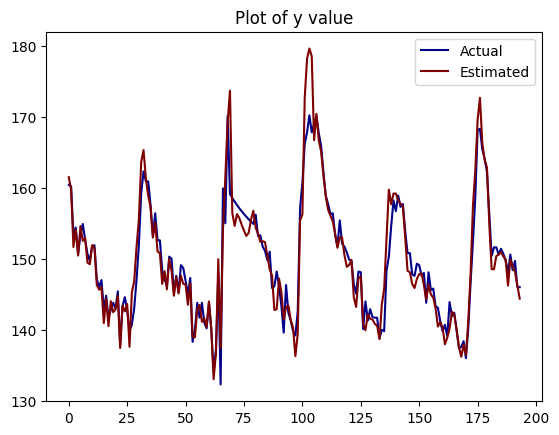

Standardized noise variance: 0.1237


In [57]:
y = np.concatenate([EG_modelling['nvdi'].values, EG_validation['nvdi'].values])
x = np.log(np.concatenate([EG_modelling['estimated_rain'].values, EG_validation['estimated_rain'].values]))

Xsave, yhat, noise_var = kalmanARMAX(y=y,x=x,A=KA, B=KB, C=KC, n_validation=n_validation)
print(f'Standardized noise variance: {round(noise_var/np.var(y), 4)}')

Looks good, lets try looping to see if we can remove a parameter

In [58]:
new_KA, new_KB, new_KC, new_var = removeParamARMAX(y, x, KA, KB, KC, n_validation, noise_var)

The variance of predicted noise when a_1 is removed: 9.752134
The variance of predicted noise when a_2 is removed: 7.514468
The variance of predicted noise when a_3 is removed: 9.857412
The variance of predicted noise when a_36 is removed: 9.428231
The variance of predicted noise when a_37 is removed: 9.883119
The variance of predicted noise when a_38 is removed: 7.570173
The variance of predicted noise when a_39 is removed: 8.076017
The variance of predicted noise when c_1 is removed: 6.819229
The variance of predicted noise when c_2 is removed: 4.4792267643362e+19
The variance of predicted noise when c_3 is removed: 114.654739
The variance of predicted noise when c_4 is removed: 7.713273
The variance of predicted noise when c_5 is removed: 7.389263
The variance of predicted noise when c_36 is removed: 10.841453
The variance of predicted noise when c_37 is removed: 18.527384
The variance of predicted noise when c_38 is removed: 7.230656
The variance of predicted noise when b_10 is rem

In [59]:
new_KA, new_KB, new_KC, new_var = removeParamARMAX(y, x, new_KA, new_KB, new_KC, n_validation, new_var)

The variance of predicted noise when a_1 is removed: 6.398775
The variance of predicted noise when a_2 is removed: 7.836548
The variance of predicted noise when a_3 is removed: 6.550699
The variance of predicted noise when a_36 is removed: 6.909033
The variance of predicted noise when a_37 is removed: 8.057534
The variance of predicted noise when a_38 is removed: 6.733504
The variance of predicted noise when a_39 is removed: 6.787461
The variance of predicted noise when c_2 is removed: 5.833808
The variance of predicted noise when c_3 is removed: 6.609917
The variance of predicted noise when c_4 is removed: 11.38064
The variance of predicted noise when c_5 is removed: 6.826879
The variance of predicted noise when c_36 is removed: 6.498731
The variance of predicted noise when c_37 is removed: 6.529334
The variance of predicted noise when c_38 is removed: 6.8543
The variance of predicted noise when b_10 is removed: 6.749123
The variance of predicted noise when b_11 is removed: 6.622716
T

In [60]:
new_KA, new_KB, new_KC, new_var = removeParamARMAX(y, x, new_KA, new_KB, new_KC, n_validation, new_var)

The variance of predicted noise when a_1 is removed: 5.190379
The variance of predicted noise when a_2 is removed: 6.434957
The variance of predicted noise when a_3 is removed: 5.510591
The variance of predicted noise when a_36 is removed: 5.691654
The variance of predicted noise when a_37 is removed: 7.767065
The variance of predicted noise when a_38 is removed: 6.522061
The variance of predicted noise when a_39 is removed: 5.590427
The variance of predicted noise when c_3 is removed: 5.432513
The variance of predicted noise when c_4 is removed: 5.840222
The variance of predicted noise when c_5 is removed: 5.713014
The variance of predicted noise when c_36 is removed: 5.717156
The variance of predicted noise when c_37 is removed: 5.968203
The variance of predicted noise when c_38 is removed: 5.889372
The variance of predicted noise when b_10 is removed: 5.777438
The variance of predicted noise when b_11 is removed: 5.530151
The variance of predicted noise when b_46 is removed: 5.83244

In [61]:
new_KA, new_KB, new_KC, new_var = removeParamARMAX(y, x, new_KA, new_KB, new_KC, n_validation, new_var)

The variance of predicted noise when a_2 is removed: 5.514171
The variance of predicted noise when a_3 is removed: 4.958558
The variance of predicted noise when a_36 is removed: 5.144375
The variance of predicted noise when a_37 is removed: 7.228118
The variance of predicted noise when a_38 is removed: 5.823349
The variance of predicted noise when a_39 is removed: 4.942193
The variance of predicted noise when c_3 is removed: 4.736466
The variance of predicted noise when c_4 is removed: 5.214138
The variance of predicted noise when c_5 is removed: 4.988533
The variance of predicted noise when c_36 is removed: 5.06314
The variance of predicted noise when c_37 is removed: 5.23992
The variance of predicted noise when c_38 is removed: 5.241844
The variance of predicted noise when b_10 is removed: 5.145327
The variance of predicted noise when b_11 is removed: 4.828402
The variance of predicted noise when b_46 is removed: 5.20167
The variance of predicted noise when b_47 is removed: 5.223978


In [62]:
new_KA, new_KB, new_KC, new_var = removeParamARMAX(y, x, new_KA, new_KB, new_KC, n_validation, new_var)

The variance of predicted noise when a_2 is removed: 4.873765
The variance of predicted noise when a_3 is removed: 5.006279
The variance of predicted noise when a_36 is removed: 4.874901
The variance of predicted noise when a_37 is removed: 6.723139
The variance of predicted noise when a_38 is removed: 5.514821
The variance of predicted noise when a_39 is removed: 4.475692
The variance of predicted noise when c_4 is removed: 4.683407
The variance of predicted noise when c_5 is removed: 4.591049
The variance of predicted noise when c_36 is removed: 4.639455
The variance of predicted noise when c_37 is removed: 4.894629
The variance of predicted noise when c_38 is removed: 4.851872
The variance of predicted noise when b_10 is removed: 4.690032
The variance of predicted noise when b_11 is removed: 4.382597
The variance of predicted noise when b_46 is removed: 4.752057
The variance of predicted noise when b_47 is removed: 4.770325
Parameter to be removed: b_11


In [63]:
new_KA, new_KB, new_KC, new_var = removeParamARMAX(y, x, new_KA, new_KB, new_KC, n_validation, new_var)

The variance of predicted noise when a_2 is removed: 4.461723
The variance of predicted noise when a_3 is removed: 4.762935
The variance of predicted noise when a_36 is removed: 4.482621
The variance of predicted noise when a_37 is removed: 6.271922
The variance of predicted noise when a_38 is removed: 5.120817
The variance of predicted noise when a_39 is removed: 4.091701
The variance of predicted noise when c_4 is removed: 4.327838
The variance of predicted noise when c_5 is removed: 4.255175
The variance of predicted noise when c_36 is removed: 4.30453
The variance of predicted noise when c_37 is removed: 4.523657
The variance of predicted noise when c_38 is removed: 4.480529
The variance of predicted noise when b_10 is removed: 4.35659
The variance of predicted noise when b_46 is removed: 4.39869
The variance of predicted noise when b_47 is removed: 4.26071
Parameter to be removed: a_39


In [64]:
new_KA, new_KB, new_KC, new_var = removeParamARMAX(y, x, new_KA, new_KB, new_KC, n_validation, new_var)

The variance of predicted noise when a_2 is removed: 4.065256
The variance of predicted noise when a_3 is removed: 4.281232
The variance of predicted noise when a_36 is removed: 5.006924
The variance of predicted noise when a_37 is removed: 5.86024
The variance of predicted noise when a_38 is removed: 4.851216
The variance of predicted noise when c_4 is removed: 4.235956
The variance of predicted noise when c_5 is removed: 3.999543
The variance of predicted noise when c_36 is removed: 4.174902
The variance of predicted noise when c_37 is removed: 4.157177
The variance of predicted noise when c_38 is removed: 4.121936
The variance of predicted noise when b_10 is removed: 4.065919
The variance of predicted noise when b_46 is removed: 4.100754
The variance of predicted noise when b_47 is removed: 3.973587
Parameter to be removed: b_47


In [65]:
new_KA, new_KB, new_KC, new_var = removeParamARMAX(y, x, new_KA, new_KB, new_KC, n_validation, new_var)

The variance of predicted noise when a_2 is removed: 3.945807
The variance of predicted noise when a_3 is removed: 4.12289
The variance of predicted noise when a_36 is removed: 4.767077
The variance of predicted noise when a_37 is removed: 5.682896
The variance of predicted noise when a_38 is removed: 4.745004
The variance of predicted noise when c_4 is removed: 4.101434
The variance of predicted noise when c_5 is removed: 3.883926
The variance of predicted noise when c_36 is removed: 4.031672
The variance of predicted noise when c_37 is removed: 4.042818
The variance of predicted noise when c_38 is removed: 4.010267
The variance of predicted noise when b_10 is removed: 3.951101
The variance of predicted noise when b_46 is removed: 3.976173
Parameter to be removed: c_5


In [66]:
new_KA, new_KB, new_KC, new_var = removeParamARMAX(y, x, new_KA, new_KB, new_KC, n_validation, new_var)

The variance of predicted noise when a_2 is removed: 3.890045
The variance of predicted noise when a_3 is removed: 4.105208
The variance of predicted noise when a_36 is removed: 4.689751
The variance of predicted noise when a_37 is removed: 5.417991
The variance of predicted noise when a_38 is removed: 4.710493
The variance of predicted noise when c_4 is removed: 3.910816
The variance of predicted noise when c_36 is removed: 3.980693
The variance of predicted noise when c_37 is removed: 3.961646
The variance of predicted noise when c_38 is removed: 4.037439
The variance of predicted noise when b_10 is removed: 3.859013
The variance of predicted noise when b_46 is removed: 3.891468
Parameter to be removed: b_10


In [67]:
new_KA, new_KB, new_KC, new_var = removeParamARMAX(y, x, new_KA, new_KB, new_KC, n_validation, new_var)

The variance of predicted noise when a_2 is removed: 3.839203
The variance of predicted noise when a_3 is removed: 4.065961
The variance of predicted noise when a_36 is removed: 4.668285
The variance of predicted noise when a_37 is removed: 5.415327
The variance of predicted noise when a_38 is removed: 4.685423
The variance of predicted noise when c_4 is removed: 3.895168
The variance of predicted noise when c_36 is removed: 3.953181
The variance of predicted noise when c_37 is removed: 3.93964
The variance of predicted noise when c_38 is removed: 4.002934
The variance of predicted noise when b_46 is removed: 3.883665
Parameter to be removed: a_2


In [68]:
new_KA, new_KB, new_KC, new_var = removeParamARMAX(y, x, new_KA, new_KB, new_KC, n_validation, new_var)

The variance of predicted noise when a_3 is removed: 3.991246
The variance of predicted noise when a_36 is removed: 4.936562
The variance of predicted noise when a_37 is removed: 6.342979
The variance of predicted noise when a_38 is removed: 5.061377
The variance of predicted noise when c_4 is removed: 3.829788
The variance of predicted noise when c_36 is removed: 3.984087
The variance of predicted noise when c_37 is removed: 3.994579
The variance of predicted noise when c_38 is removed: 4.089129
The variance of predicted noise when b_46 is removed: 3.828235
Parameter to be removed: b_46


In [69]:
new_KA, new_KB, new_KC, new_var = removeParamARMAX(y, x, new_KA, new_KB, new_KC, n_validation, new_var)

The variance of predicted noise when a_3 is removed: 3.99712
The variance of predicted noise when a_36 is removed: 5.006911
The variance of predicted noise when a_37 is removed: 6.394868
The variance of predicted noise when a_38 is removed: 4.993453
The variance of predicted noise when c_4 is removed: 3.811393
The variance of predicted noise when c_36 is removed: 3.988552
The variance of predicted noise when c_37 is removed: 4.016345
The variance of predicted noise when c_38 is removed: 4.069195
Parameter to be removed: c_4


In [70]:
new_KA, new_KB, new_KC, new_var = removeParamARMAX(y, x, new_KA, new_KB, new_KC, n_validation, new_var)

The variance of predicted noise when a_3 is removed: 4.009569
The variance of predicted noise when a_36 is removed: 4.909065
The variance of predicted noise when a_37 is removed: 6.757967
The variance of predicted noise when a_38 is removed: 4.799541
The variance of predicted noise when c_36 is removed: 3.920583
The variance of predicted noise when c_37 is removed: 4.20268
The variance of predicted noise when c_38 is removed: 4.019984
It is better to not remove any parameters


The variance of predicted noise: 3.811393


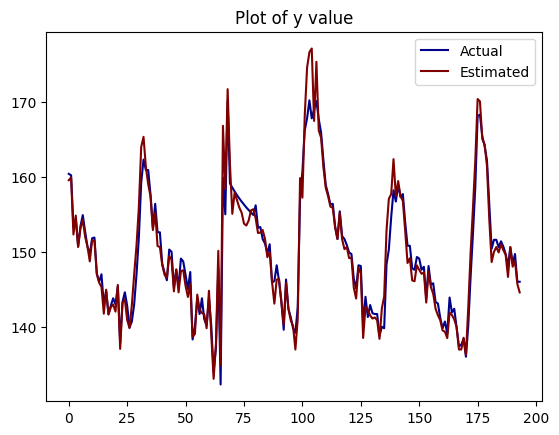

Standardized noise variance: 0.0657


In [71]:
Xsave, yhat, noise_var = kalmanARMAX(y=y,x=x,A=new_KA, B=new_KB, C=new_KC, n_validation=n_validation)
print(f'Standardized noise variance: {round(noise_var/np.var(y), 4)}')

The variance of predicted noise: 6.271708


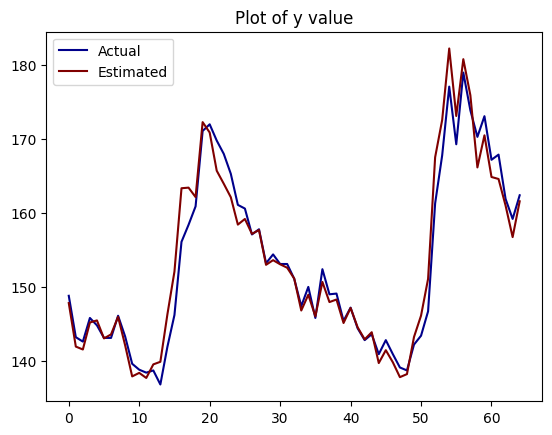

Standardized noise variance: 0.0916


In [72]:
y = np.concatenate([EG_modelling['nvdi'].values, EG_validation['nvdi'].values, EG_testing['nvdi'].values])
x = np.log(np.concatenate([EG_modelling['estimated_rain'].values, EG_validation['estimated_rain'].values, EG_testing['estimated_rain'].values]))
Xsave, yhat, noise_var = kalmanARMAX(y=y,x=x,A=new_KA, B=new_KB, C=new_KC, n_validation=n_test)
print(f'Standardized noise variance: {round(noise_var/np.var(y), 4)}')

# Modeling for Kassala

In [73]:
y = Kassala['rain_org'].values
y = y[:len(y)-960]
y = y + 1e-2

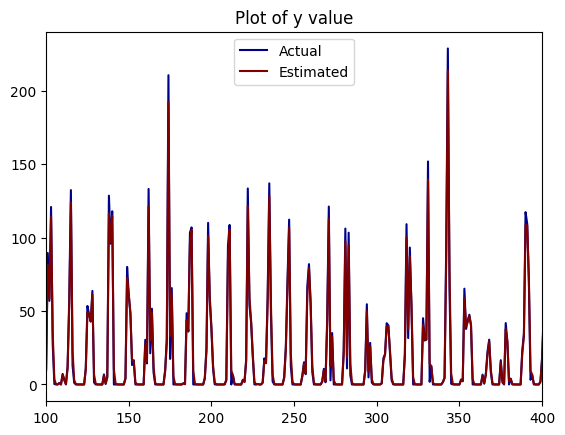

In [74]:
# Using data perform kalman gain to get the AR(1) coefficient
N = len(y)
a1 = min_a1   # Value of A1 parameter
A = np.array([[-a1, 0, 0], [1, 0, 0], [0, 1, 0]])
Re = 50 * np.eye(3)   #   How fast changes of estimates are reflected. Since y_t = x_t + x_t-1 + x_t-2 exactly, we have to use big values of Re to see this.
Rw = 100    # How noisy the estimate will be

Rxx1 = 10 * np.eye(3)    # How confident we are with initial states
# xtt1 = np.array([y[0]/3]*3)    # Set initial states as the first value of rain/3
xtt1 = np.array([0]*3)    # Set initial states as 0

Xsave = np.zeros((3, N))
ehat = np.zeros(N)
yhat = np.zeros(N)

for t in range(0, N):
    Ct = np.array([1,1,1]).reshape(1, -1)
    Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
    Kt = np.dot(np.dot(Rxx1, Ct.T), np.linalg.inv(Ryy))
    yhat[t] = np.dot(Ct, xtt1).item()

    ehat[t] = y[t] - yhat[t]
    Xsave[:,t] = xtt1 + np.dot(Kt, ehat[t]).T
    Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)

    xtt1 = np.dot(A, Xsave[:,t])
    Rxx1 = np.dot(np.dot(A, Rxx), A.T) + Re
    
# Plot the estimated y with actual y
x_val = []
for i in range(len(Xsave[0])):
    x_val += [Xsave[0][i], Xsave[1][i], Xsave[2][i]]
plt.plot(y[:-1], color='darkblue', label='Actual')
plt.plot(yhat[1:], color='maroon', label='Estimated')
plt.xlim(100, 400)
plt.title('Plot of y value')
plt.legend()
plt.show()

In [75]:
Kassala['estimated_rain'] = x_val[1:] + [0]
Kassala_df = Kassala[~np.isnan(Kassala['nvdi_t'])]
Kassala_df.head(10)

,nvdi,nvdi_t,rain,rain_t,rain_org,rain_org_t,estimated_rain
0,146.0,1982.013889,0.0,1960.013889,0.0,1960.041667,0.000769
1,147.9,1982.041667,0.0,1960.041667,0.0,1960.125000,0.000769
2,142.4,1982.069444,0.0,1960.069444,0.0,1960.208333,0.002535
3,143.0,1982.097222,0.0,1960.097222,0.0,1960.291667,0.002547
4,144.3,1982.125000,0.0,1960.125000,16.5,1960.375000,0.002287
5,142.6,1982.152778,0.0,1960.152778,40.1,1960.458333,0.003217
6,139.1,1982.180556,0.0,1960.180556,92.0,1960.541667,0.003247
7,143.7,1982.208333,0.0,1960.208333,46.8,1960.625000,0.002989
8,145.9,1982.236111,0.0,1960.236111,97.9,1960.708333,0.003290
9,138.7,1982.263889,0.0,1960.263889,0.0,1960.791667,0.003323


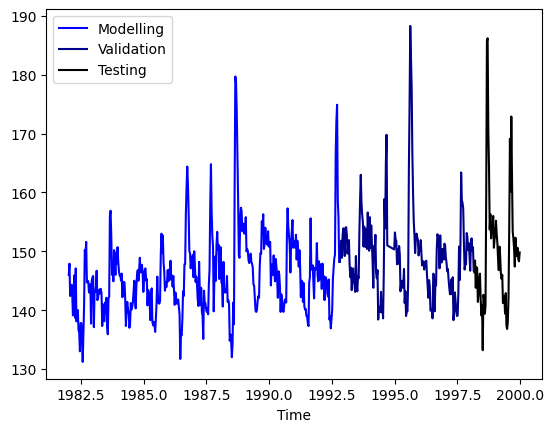

In [76]:
n_modelling = round(Kassala_df.shape[0] * .6)
n_validation = round(Kassala_df.shape[0] * .3)
n_test = round(Kassala_df.shape[0] * .1)
K_modelling = Kassala_df.iloc[:n_modelling]
K_validation = Kassala_df.iloc[n_modelling:n_modelling+n_validation]
K_testing = Kassala_df.iloc[n_modelling+n_validation:]
plt.plot(K_modelling['nvdi_t'],K_modelling['nvdi'], color='b', label='Modelling')
plt.plot(K_validation['nvdi_t'],K_validation['nvdi'], color='darkblue', label='Validation')
plt.plot(K_testing['nvdi_t'], K_testing['nvdi'], color='black', label='Testing')
plt.legend()
plt.xlabel('Time')
plt.show()

The variance of predicted noise: 19.091454


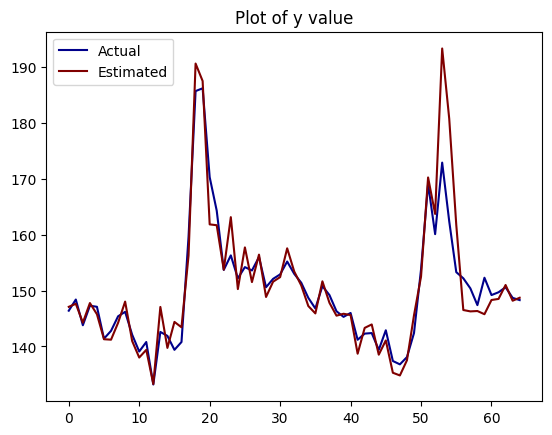

Standardized noise variance: 0.3393


In [77]:
y = np.concatenate([K_modelling['nvdi'].values, K_validation['nvdi'].values, K_testing['nvdi'].values])
x = np.log(np.concatenate([K_modelling['estimated_rain'].values, K_validation['estimated_rain'].values, K_testing['estimated_rain'].values]))

Xsave, yhat, noise_var = kalmanARMAX(y=y,x=x,A=KA, B=KB, C=KC, n_validation=n_test)
print(f'Standardized noise variance: {round(noise_var/np.var(y), 4)}')

The variance of predicted noise: 16.813482


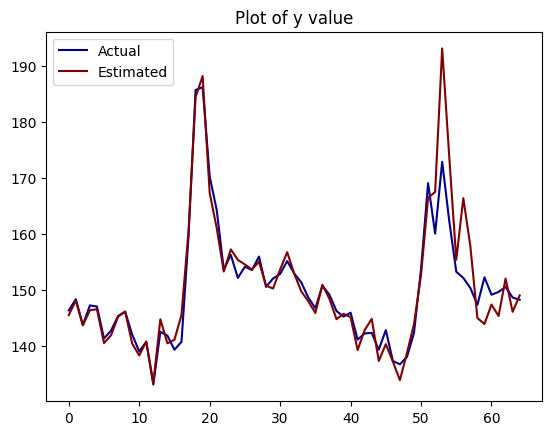

Standardized noise variance: 0.2988


In [78]:
Xsave, yhat, noise_var = kalmanARMAX(y=y,x=x,A=new_KA, B=new_KB, C=new_KC, n_validation=n_test)
print(f'Standardized noise variance: {round(noise_var/np.var(y), 4)}')